# ABC on real insurance data 

In this notebook we are considering three motor insurance data set 

In [1]:
from preamble import *
from infer_loss_distribution import *
from infer_count_distribution import *

%config InlineBackend.figure_format = 'retina'
%load_ext lab_black

In [2]:
# dill.load_session("Real_Data_Application.pkl")

In [3]:
import sys

print("ABC version:", abc.__version__)
print("Python version:", sys.version)
print("Numpy version:", np.__version__)
print("PyMC3 version:", pm.__version__)
print("Arviz version:", arviz.__version__)

tic()

ABC version: 0.1.1
Python version: 3.8.10 (default, May 19 2021, 18:05:58) 
[GCC 7.3.0]
Numpy version: 1.20.3
PyMC3 version: 3.11.2
Arviz version: 0.11.2


In [4]:
FAST = False

# Processor information and SMC calibration parameters
if not FAST:
    numIters = 15
    numItersData = 20
    popSize = 1000
    popSizeModels = 1000
    epsMin = 0
    timeout = 1000
else:
    numIters = 3
    numItersData = 5
    popSize = 500
    popSizeModels = 1000
    epsMin = 1
    timeout = 30

smcArgs = {"timeout": timeout, "epsMin": epsMin, "verbose": True}
smcArgs["numProcs"] = 40

## The Australian data set 

Hereafter the code to import and display the first five observations of the data along with some descriptive stats

In [5]:
from IPython.display import display_html

ausautoBI8999 = pd.read_csv("Data/ausautoBI8999.csv")
aus = ausautoBI8999[["FinDate", "FinMth", "AggClaim"]]
print(aus.head(5).to_latex(index=False))
print(aus[["AggClaim"]].describe().applymap("{:.2e}".format).to_latex())
# df1 = aus.head(5)
# df2 = aus.describe()
# df1_styler = df1.style.set_table_attributes("style='display:inline'").set_caption('First 5 observations')
# df2_styler = df2.style.set_table_attributes("style='display:inline'").set_caption('Descriptive stats')
# display_html(df1_styler._repr_html_() +" "+ df2_styler._repr_html_(), raw=True)

\begin{tabular}{lrr}
\toprule
   FinDate &  FinMth &  AggClaim \\
\midrule
1993-10-01 &      52 &     87.75 \\
1994-02-01 &      56 &    353.62 \\
1994-02-01 &      56 &    688.83 \\
1994-05-01 &      59 &    172.80 \\
1994-09-01 &      63 &     43.29 \\
\bottomrule
\end{tabular}

\begin{tabular}{ll}
\toprule
{} &  AggClaim \\
\midrule
count &  2.20e+04 \\
mean  &  3.84e+04 \\
std   &  9.10e+04 \\
min   &  9.96e+00 \\
25\%   &  6.30e+03 \\
50\%   &  1.39e+04 \\
75\%   &  3.51e+04 \\
max   &  4.49e+06 \\
\bottomrule
\end{tabular}



Hereafter is an histogram of the claim sizes

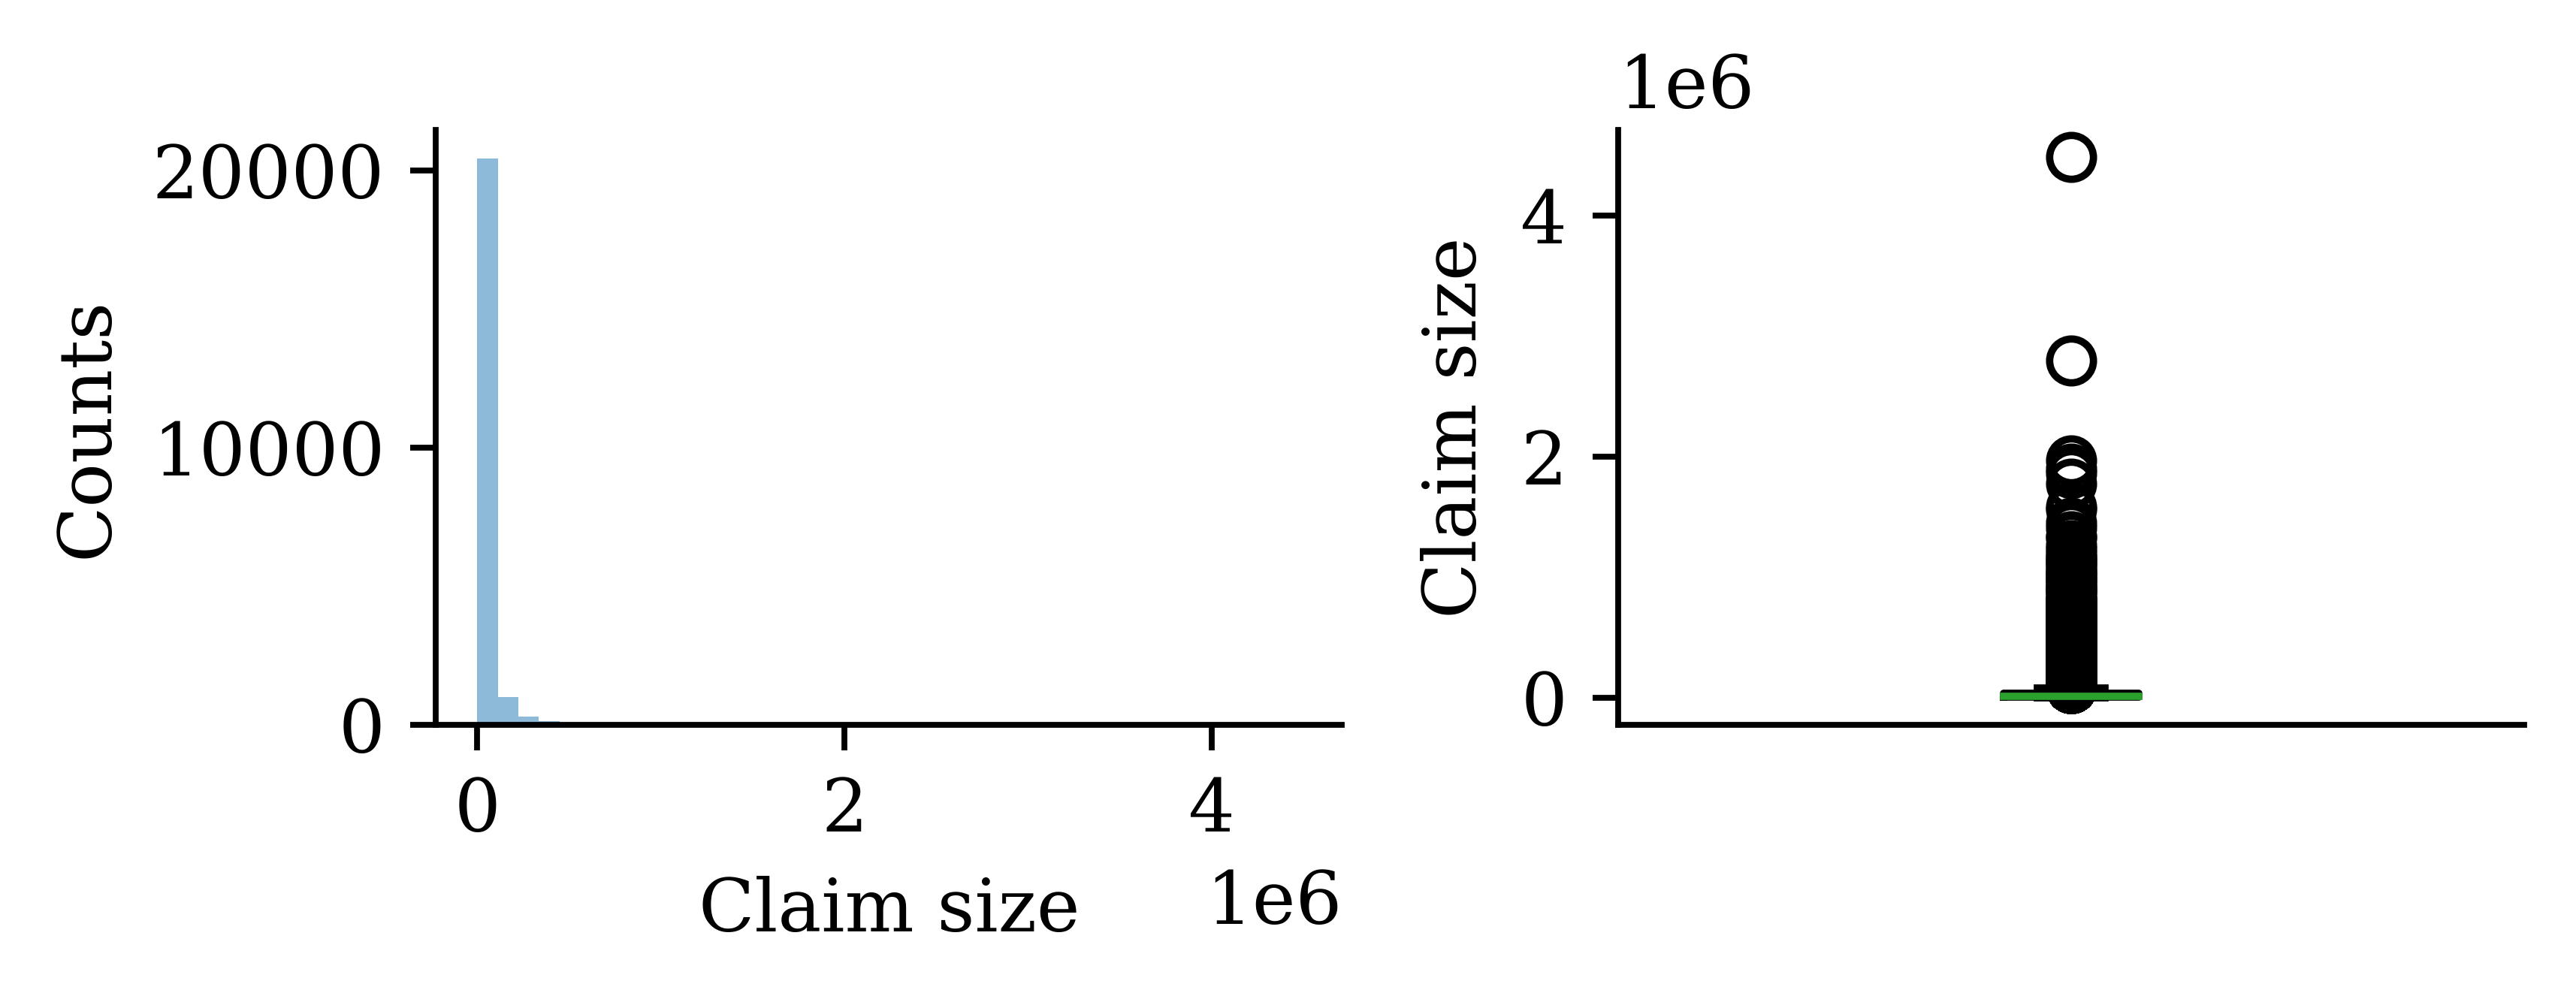

In [6]:
fig, axs = plt.subplots(1, 2, tight_layout=True)
num_bins = 40
# the histogram of the data
n, bins, patches = axs[0].hist(aus.AggClaim, num_bins, alpha=0.5)
axs[1].boxplot(aus.AggClaim)
axs[0].set_xlabel("Claim size")
axs[0].set_ylabel("Counts")
axs[1].set_ylabel("Claim size")
axs[1].set_xticks([])
# plt.show()
sns.despine()
# save_cropped("../Figures/hist-box-aus.pdf")

We note from the plots that we have a high proportion of small claims and a couple of large claims. This indicates a long right tail which is typical in insurance data.

We consider three models for the claim sizes including 
- gamma
- weibull 
- lognormal. 

Given the number of data points (22 036), Bayesian inference is impractible so the parameters of the model via standard methods such as MLE and MME

In [7]:
%run -i ./infer_loss_distribution.py
# The models considered are
models_sev = ["gamma", "weibull", "lognormal"]
# The first guess for the parameters are
θ0 = (1, 1)
# The individual claim sizes are fed to the function under a list format

uData = list(np.array(aus.AggClaim))
# uData = list(np.array(aus.AggClaim)[np.random.choice(len(aus.AggClaim), 69)])

mle_summary = infer_loss(uData, models_sev, θ0)
print(
    pd.concat(
        [
            mle_summary[["model"]],
            mle_summary[["param1", "param2", "BIC"]].applymap("{:.2e}".format),
        ],
        axis=1,
    ).to_latex()
)

\begin{tabular}{lllll}
\toprule
{} &      model &    param1 &    param2 &       BIC \\
\midrule
0 &      gamma &  6.19e-01 &  6.15e+04 &  5.05e+05 \\
1 &    weibull &  7.09e-01 &  2.87e+04 &  5.03e+05 \\
2 &  lognormal &  9.56e+00 &  1.46e+00 &  5.00e+05 \\
\bottomrule
\end{tabular}



In [8]:
rg = default_rng(1)
μ_mle = mle_summary[mle_summary["model"] == "lognormal"].param1.array
σ_mle = mle_summary[mle_summary["model"] == "lognormal"].param2.array
α_mle = mle_summary[mle_summary["model"] == "gamma"].param1.array
β_mle = mle_summary[mle_summary["model"] == "gamma"].param2.array
k_mle = mle_summary[mle_summary["model"] == "weibull"].param1.array
δ_mle = mle_summary[mle_summary["model"] == "weibull"].param2.array

qs = np.arange(0.01, 0.99, 0.01)

df_quantile = pd.DataFrame(
    {
        "emp_quant": pd.Series(uData).quantile(qs),
        "lnorm_quant": pd.Series(
            abc.simulate_claim_sizes(rg, len(uData), "lognormal", (μ_mle, σ_mle))
        ).quantile(qs),
        "gamma_quant": pd.Series(
            abc.simulate_claim_sizes(rg, len(uData), "gamma", (α_mle, β_mle))
        ).quantile(qs),
        "weibull_quant": pd.Series(
            abc.simulate_claim_sizes(rg, len(uData), "weibull", (k_mle, δ_mle))
        ).quantile(qs),
    }
)

The lowest BIC is reached for the lognormal distribution. The following quantiles-quantiles plot tends to confirm this result. 

In [9]:
gamColor = colors[0]
weibColor = colors[1]
lnormColor = colors[2]

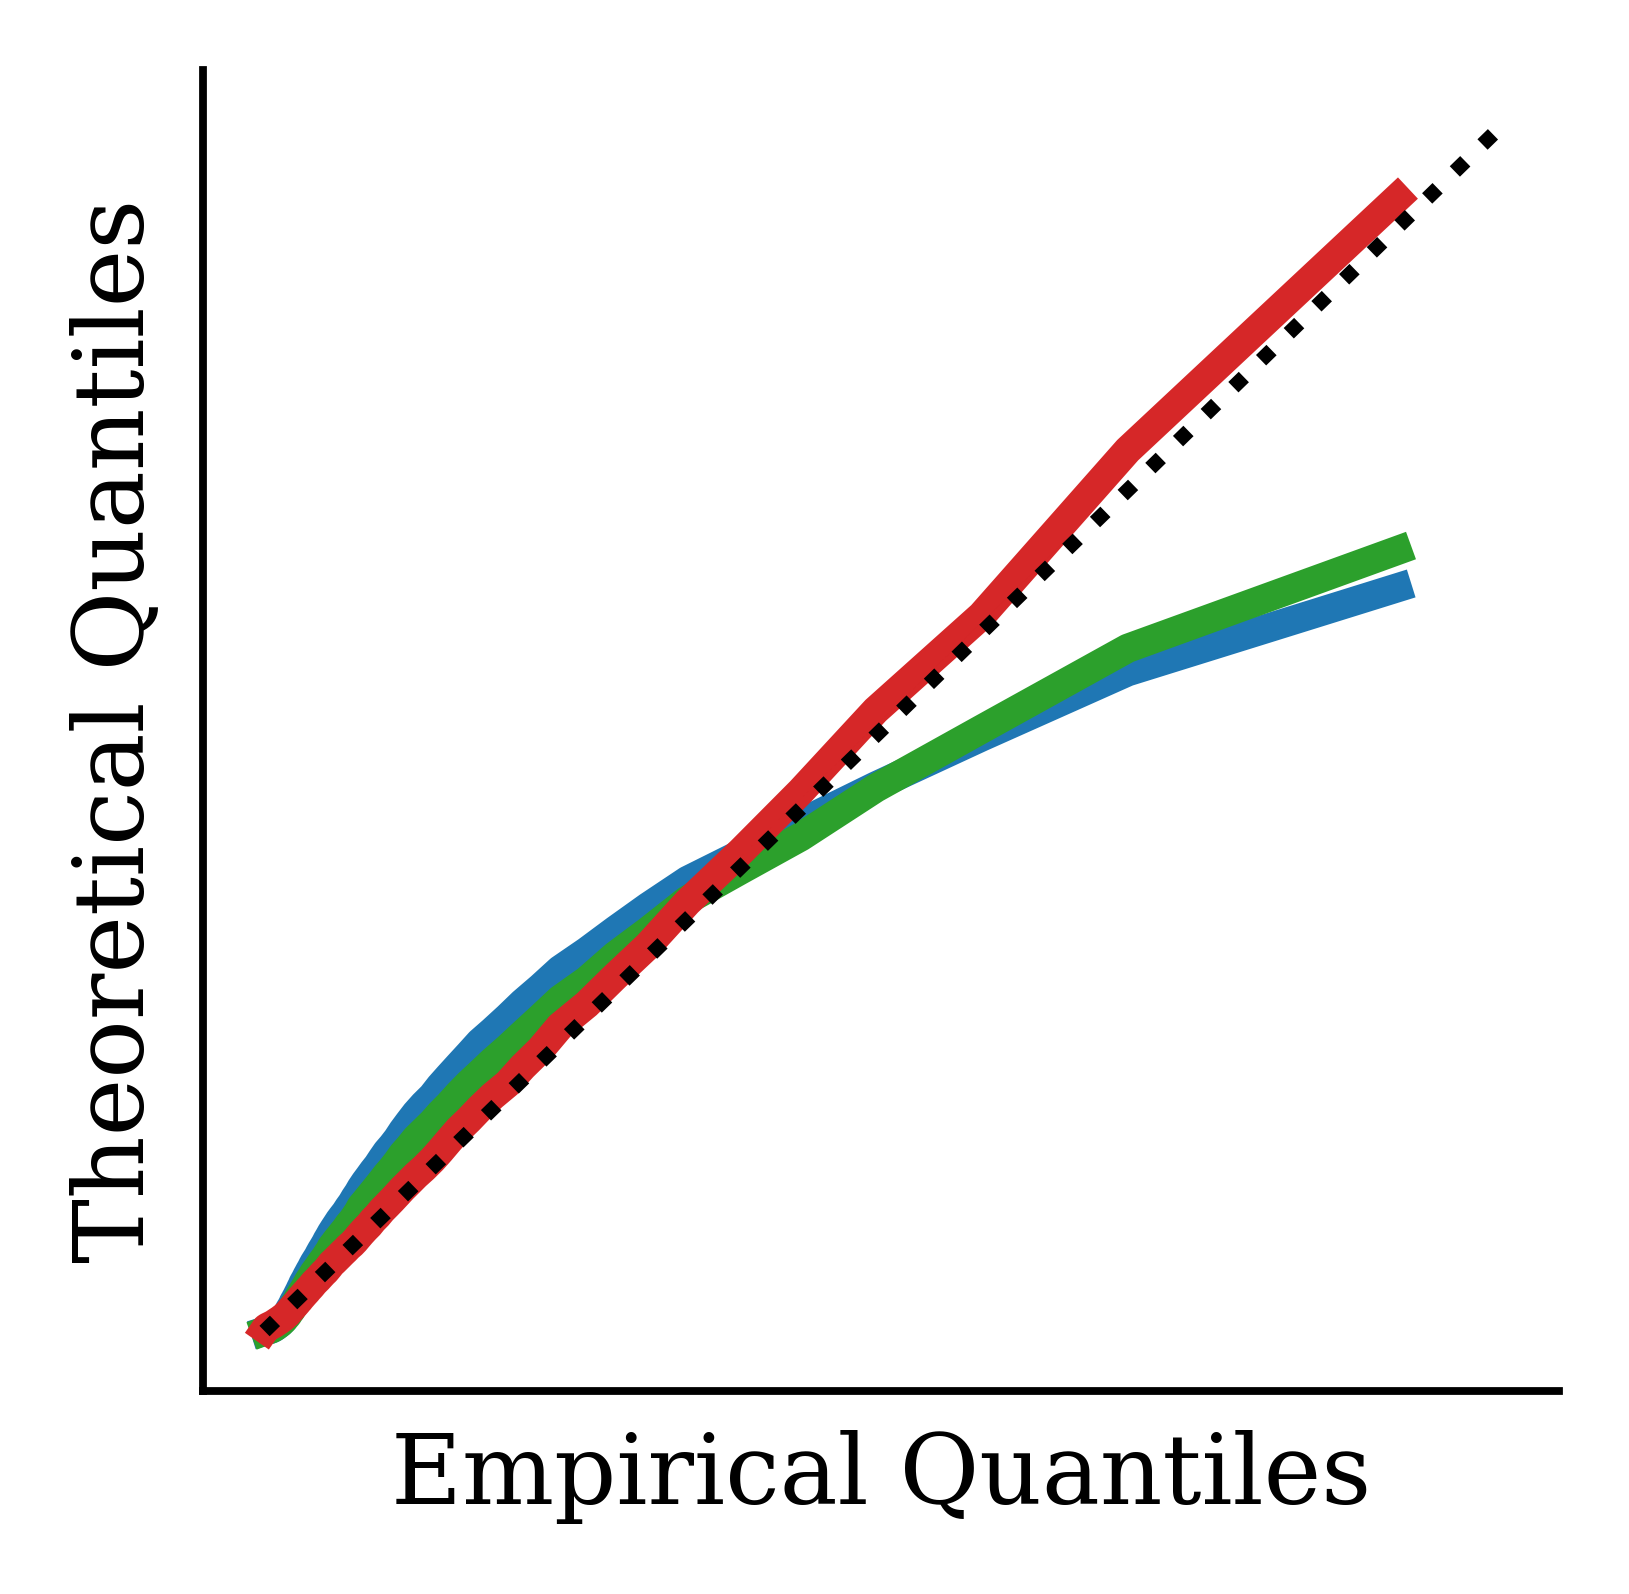

In [10]:
# Quantile-quantile plots
fig, axs = plt.subplots(1, 1, figsize=(2.5, 2.5))

plt.plot(df_quantile.emp_quant, df_quantile.gamma_quant, c=gamColor, lw=3)
plt.plot(df_quantile.emp_quant, df_quantile.weibull_quant, c=weibColor, lw=3)
plt.plot(df_quantile.emp_quant, df_quantile.lnorm_quant, c=lnormColor, lw=3)

x = np.linspace(0, 3 * 10 ** 5, 100)

plt.plot(x, x, ":k")
plt.xticks([])
plt.yticks([])
plt.xlabel("Empirical Quantiles")
plt.ylabel("Theoretical Quantiles")

sns.despine()
save_cropped("../Figures/qqplots-aus.pdf")

The lognormal distribution seems to provide the best fit. We can study the stationarity of the loss distribution over the time period not to be sure to mix up apples and oranges as we aggregate the whole data set. 

In [11]:
models_sev = ["gamma", "weibull", "lognormal"]

# The first guess for the parameters are
θ0 = (1, 1)

# The individual claim sizes are fed to the function under a list format
time_periods = np.sort(aus.FinMth.value_counts().index)
mle_time_periods = pd.concat(
    [
        infer_loss(
            list(np.array(aus.AggClaim[aus.FinMth == time_period])), models_sev, θ0
        )
        for time_period in time_periods
    ]
)
mle_time_periods["FinMth"] = pd.concat(
    [pd.Series(np.repeat(time_period, len(models_sev))) for time_period in time_periods]
)
mle_time_periods[["model", "param1", "param2"]].groupby("model").agg([np.mean, np.std])

param1                  param2              
               mean       std          mean           std
model                                                    
gamma      0.634045  0.073810  60881.500267  17984.527639
lognormal  9.523702  0.231361      1.462699      0.133209
weibull    0.719504  0.049485  28445.018165   5603.828501

We can then plot the model probabilities over the time periods

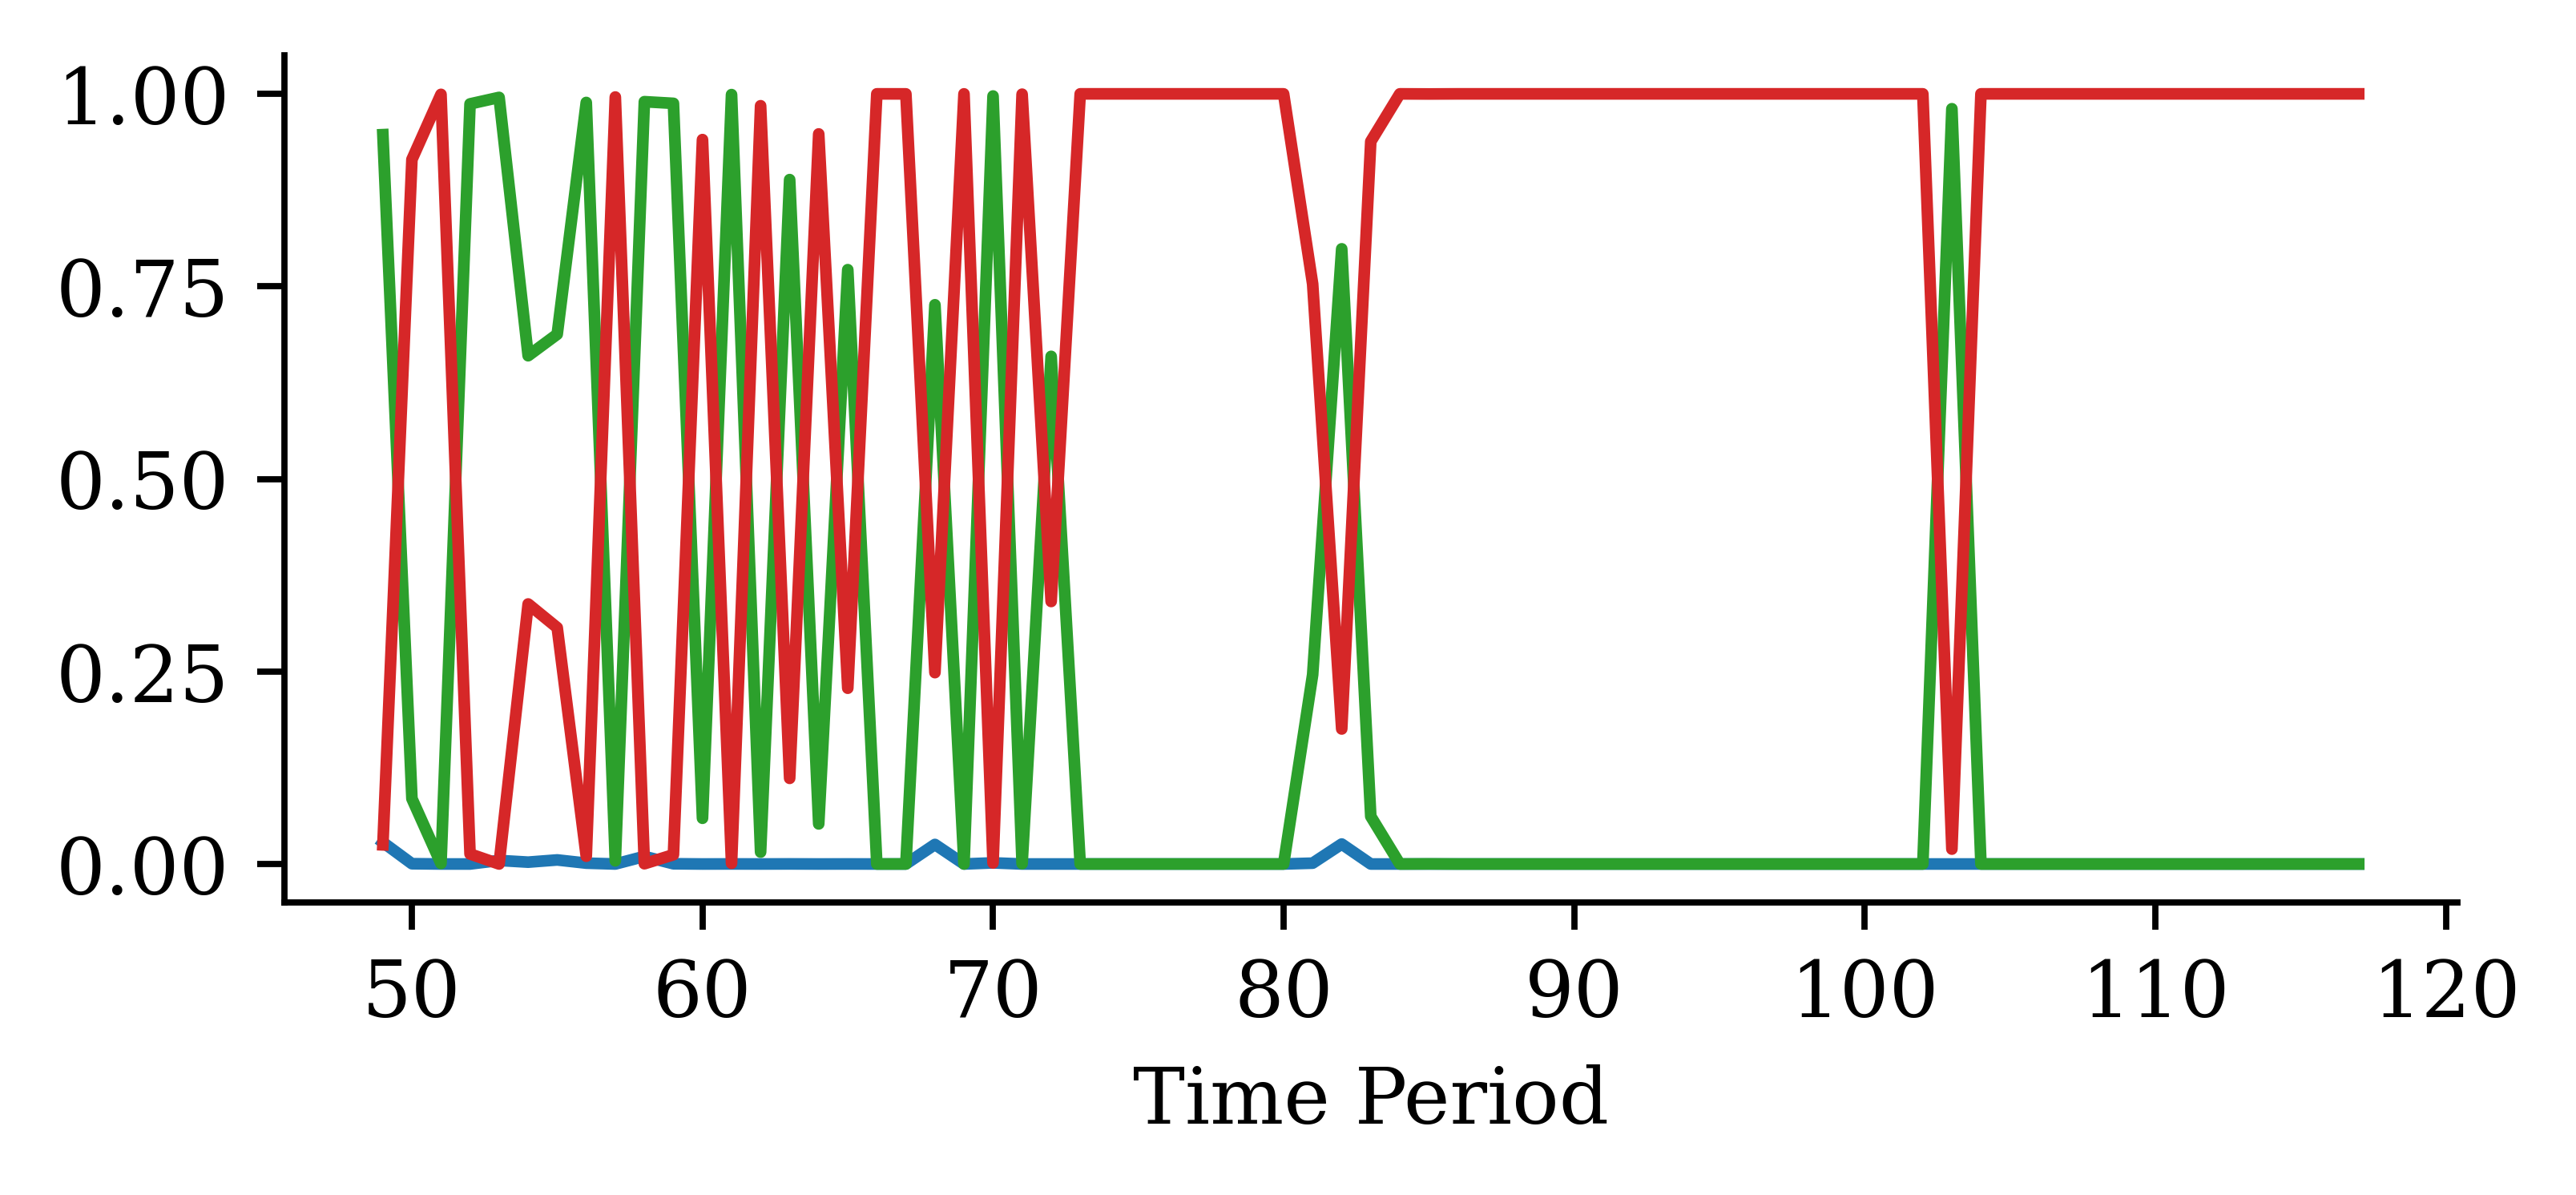

In [12]:
plt.plot(
    time_periods,
    mle_time_periods[mle_time_periods.model == "gamma"].model_prob,
    c=gamColor,
    label="Gamma",
    #     marker="o",
    #     markersize=6,
)
plt.plot(
    time_periods,
    mle_time_periods[mle_time_periods.model == "weibull"].model_prob,
    c=weibColor,
    label="Weibull",
    #     marker="d",
    #     markersize=6,
)
plt.plot(
    time_periods,
    mle_time_periods[mle_time_periods.model == "lognormal"].model_prob,
    c=lnormColor,
    label="Lognormal",
    #     marker="s",
    #     markersize=6,
)
plt.xlabel("Time Period")
# plt.title("Model Evidence")
# plt.legend(loc="right", frameon=False)
sns.despine()
save_cropped("../Figures/model-prob-aus.pdf")

The lognormal model seems to be consistently the best one over all the time period. To observe if there is some stationarity, we investigate the behavior the parameters accross the time periods. 

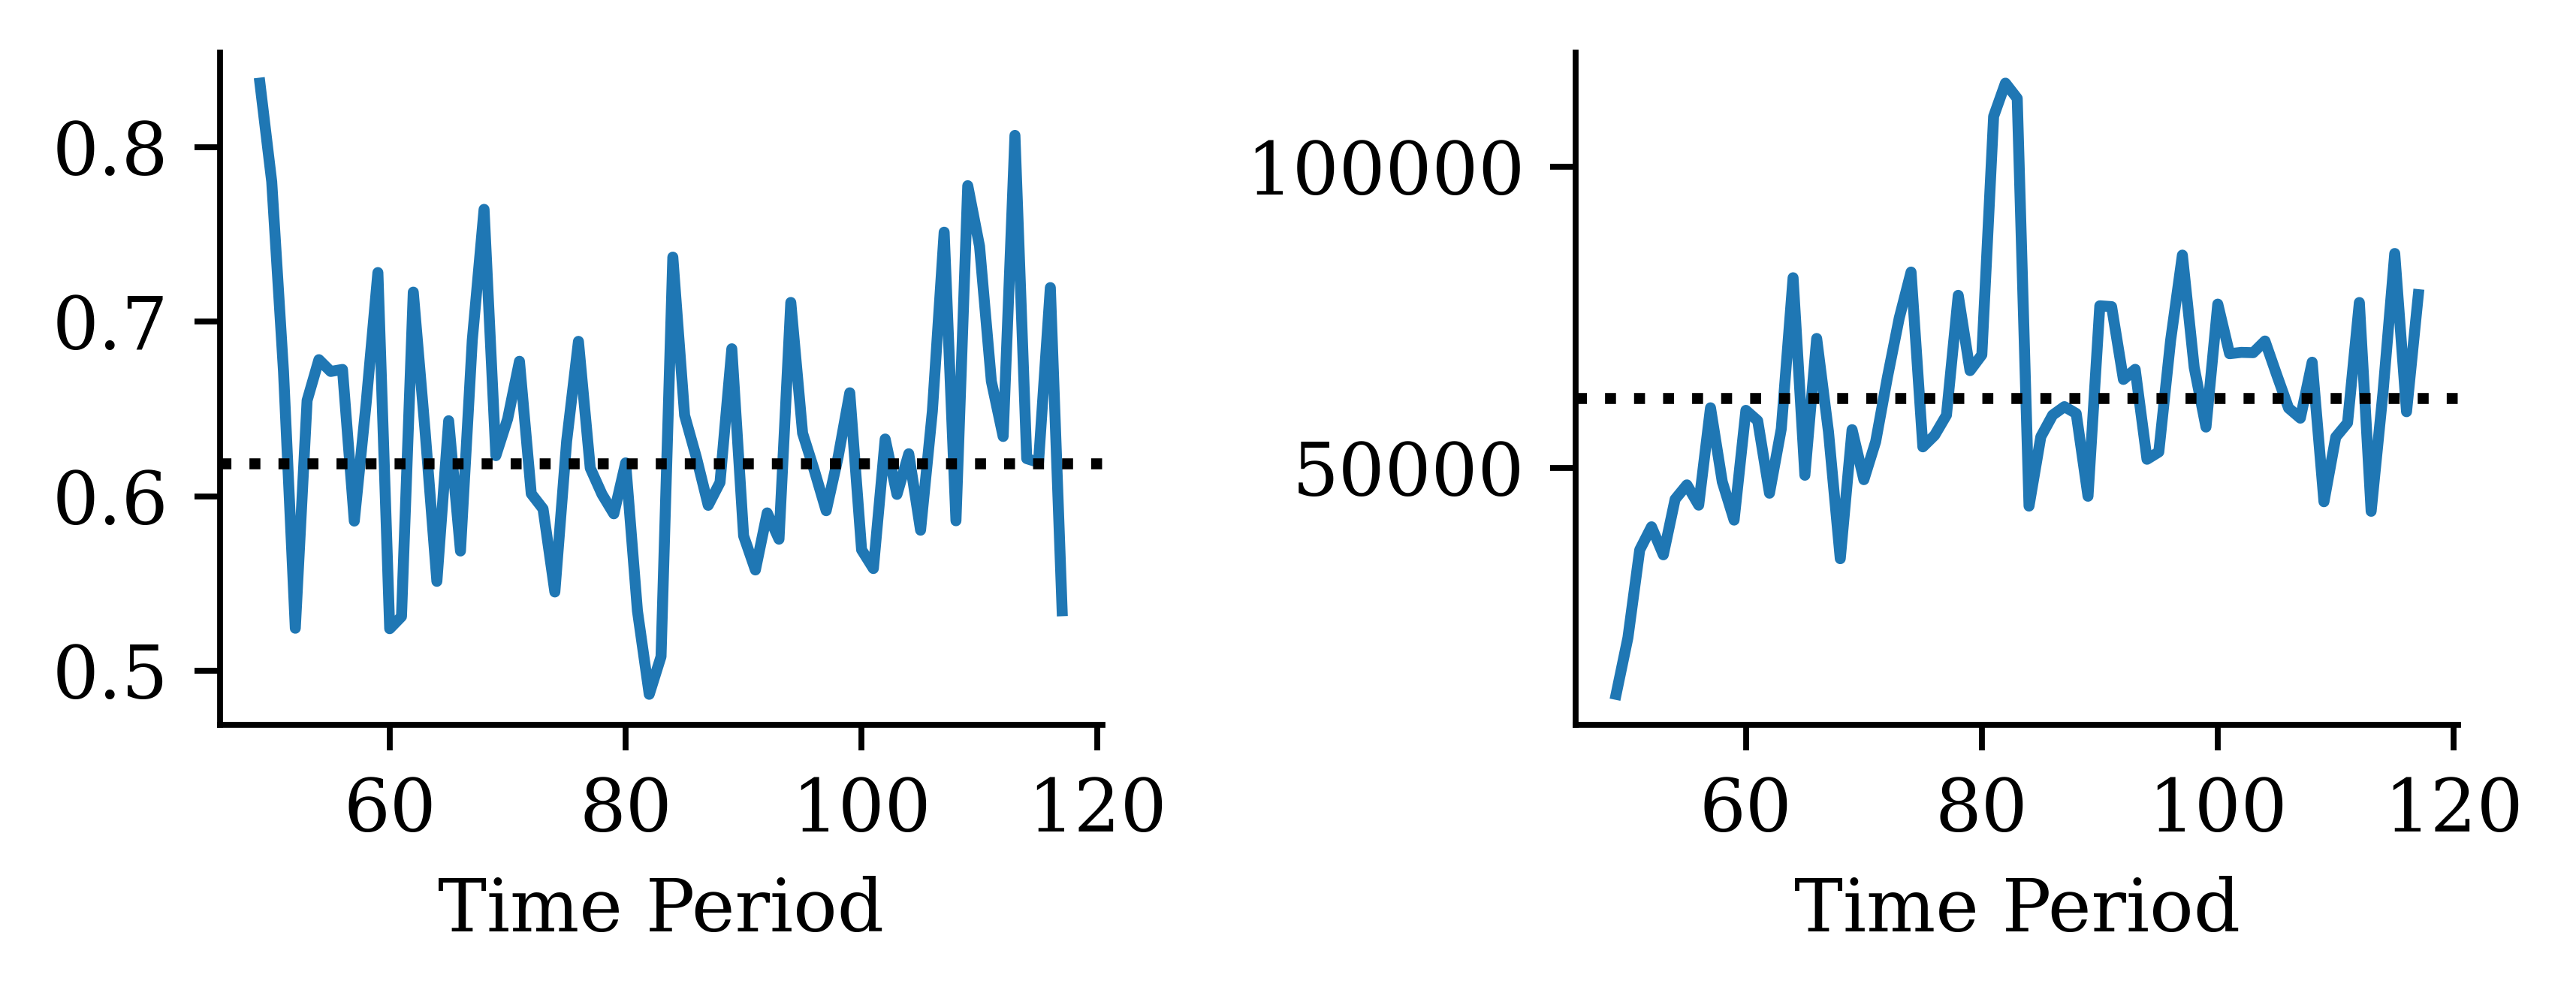

In [13]:
fig, axs = plt.subplots(1, 2, tight_layout=True)

# the histogram of the data
axs[0].plot(
    time_periods, mle_time_periods[mle_time_periods.model == "gamma"].param1, c=gamColor
)
axs[0].set_xlabel("Time Period")
# axs[0].set_title("$r$")
axs[0].axhline(y=α_mle, **mleStyle)

axs[1].plot(
    time_periods, mle_time_periods[mle_time_periods.model == "gamma"].param2, c=gamColor
)
axs[1].set_xlabel("Time Period")
# axs[1].set_title("$m$")
axs[1].axhline(y=β_mle, **mleStyle)

sns.despine()
save_cropped("../Figures/aus-gamma-params.pdf")

Both parameter demonstrate large variation accross the time period, potentially due to the lack of fit of the gamma disribution to the data.

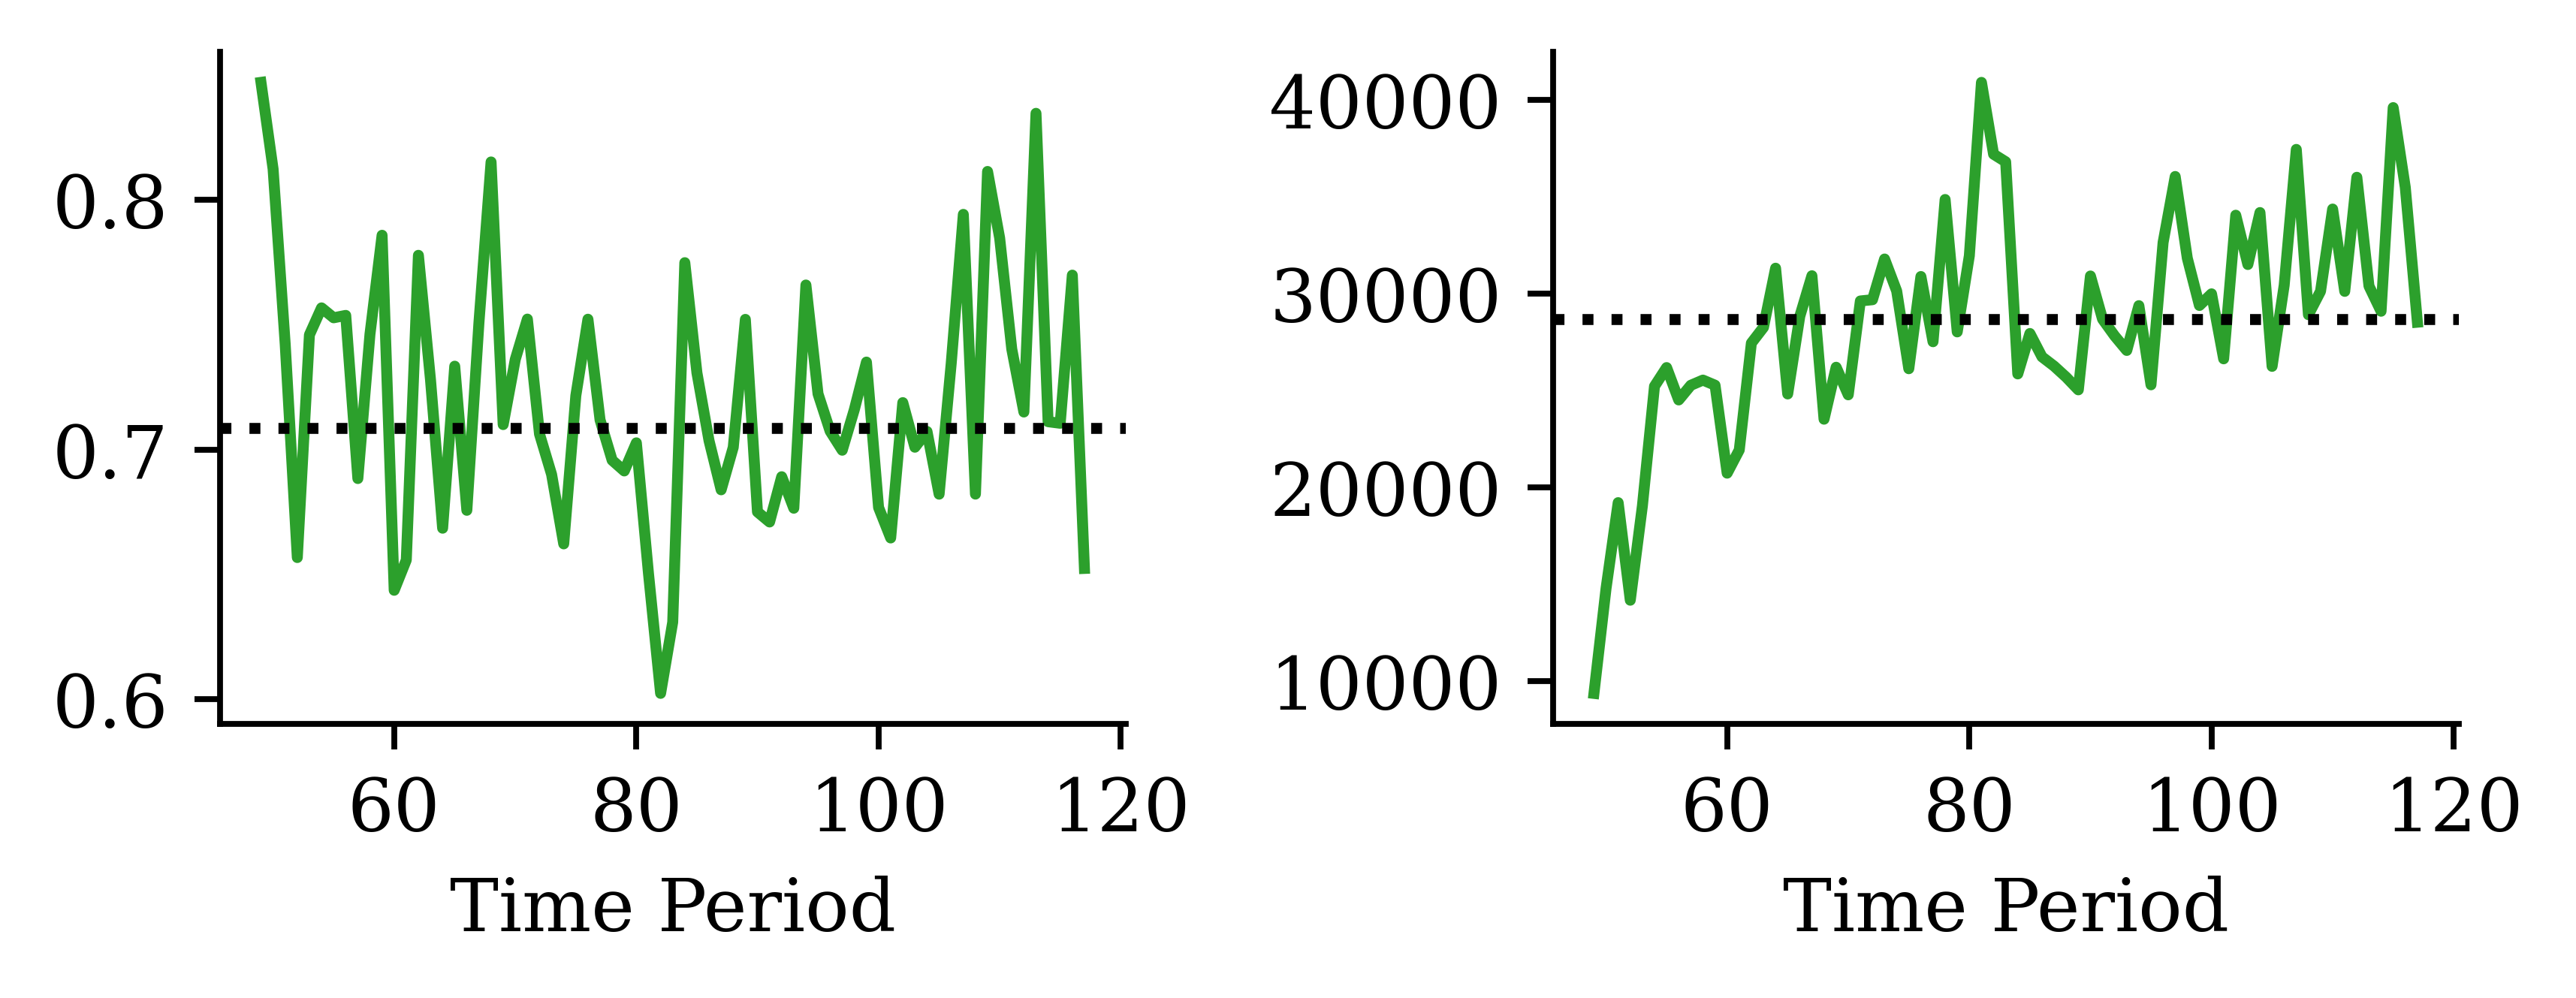

In [14]:
fig, axs = plt.subplots(1, 2, tight_layout=True)

# the histogram of the data
axs[0].plot(
    time_periods,
    mle_time_periods[mle_time_periods.model == "weibull"].param1,
    c=weibColor,
)
axs[0].set_xlabel("Time Period")
# axs[0].set_title("$k$")
axs[0].axhline(y=k_mle, **mleStyle)

axs[1].plot(
    time_periods,
    mle_time_periods[mle_time_periods.model == "weibull"].param2,
    c=weibColor,
)
axs[1].set_xlabel("Time Period")
# axs[1].set_title("$\\beta$")
axs[1].axhline(y=δ_mle, **mleStyle)

sns.despine()
save_cropped("../Figures/aus-weibull-params.pdf")

Just like for the gamma distribution the parameters of the weibull distribution exhibit a high volatility. These results are consistent with the analysis of the overall data set.

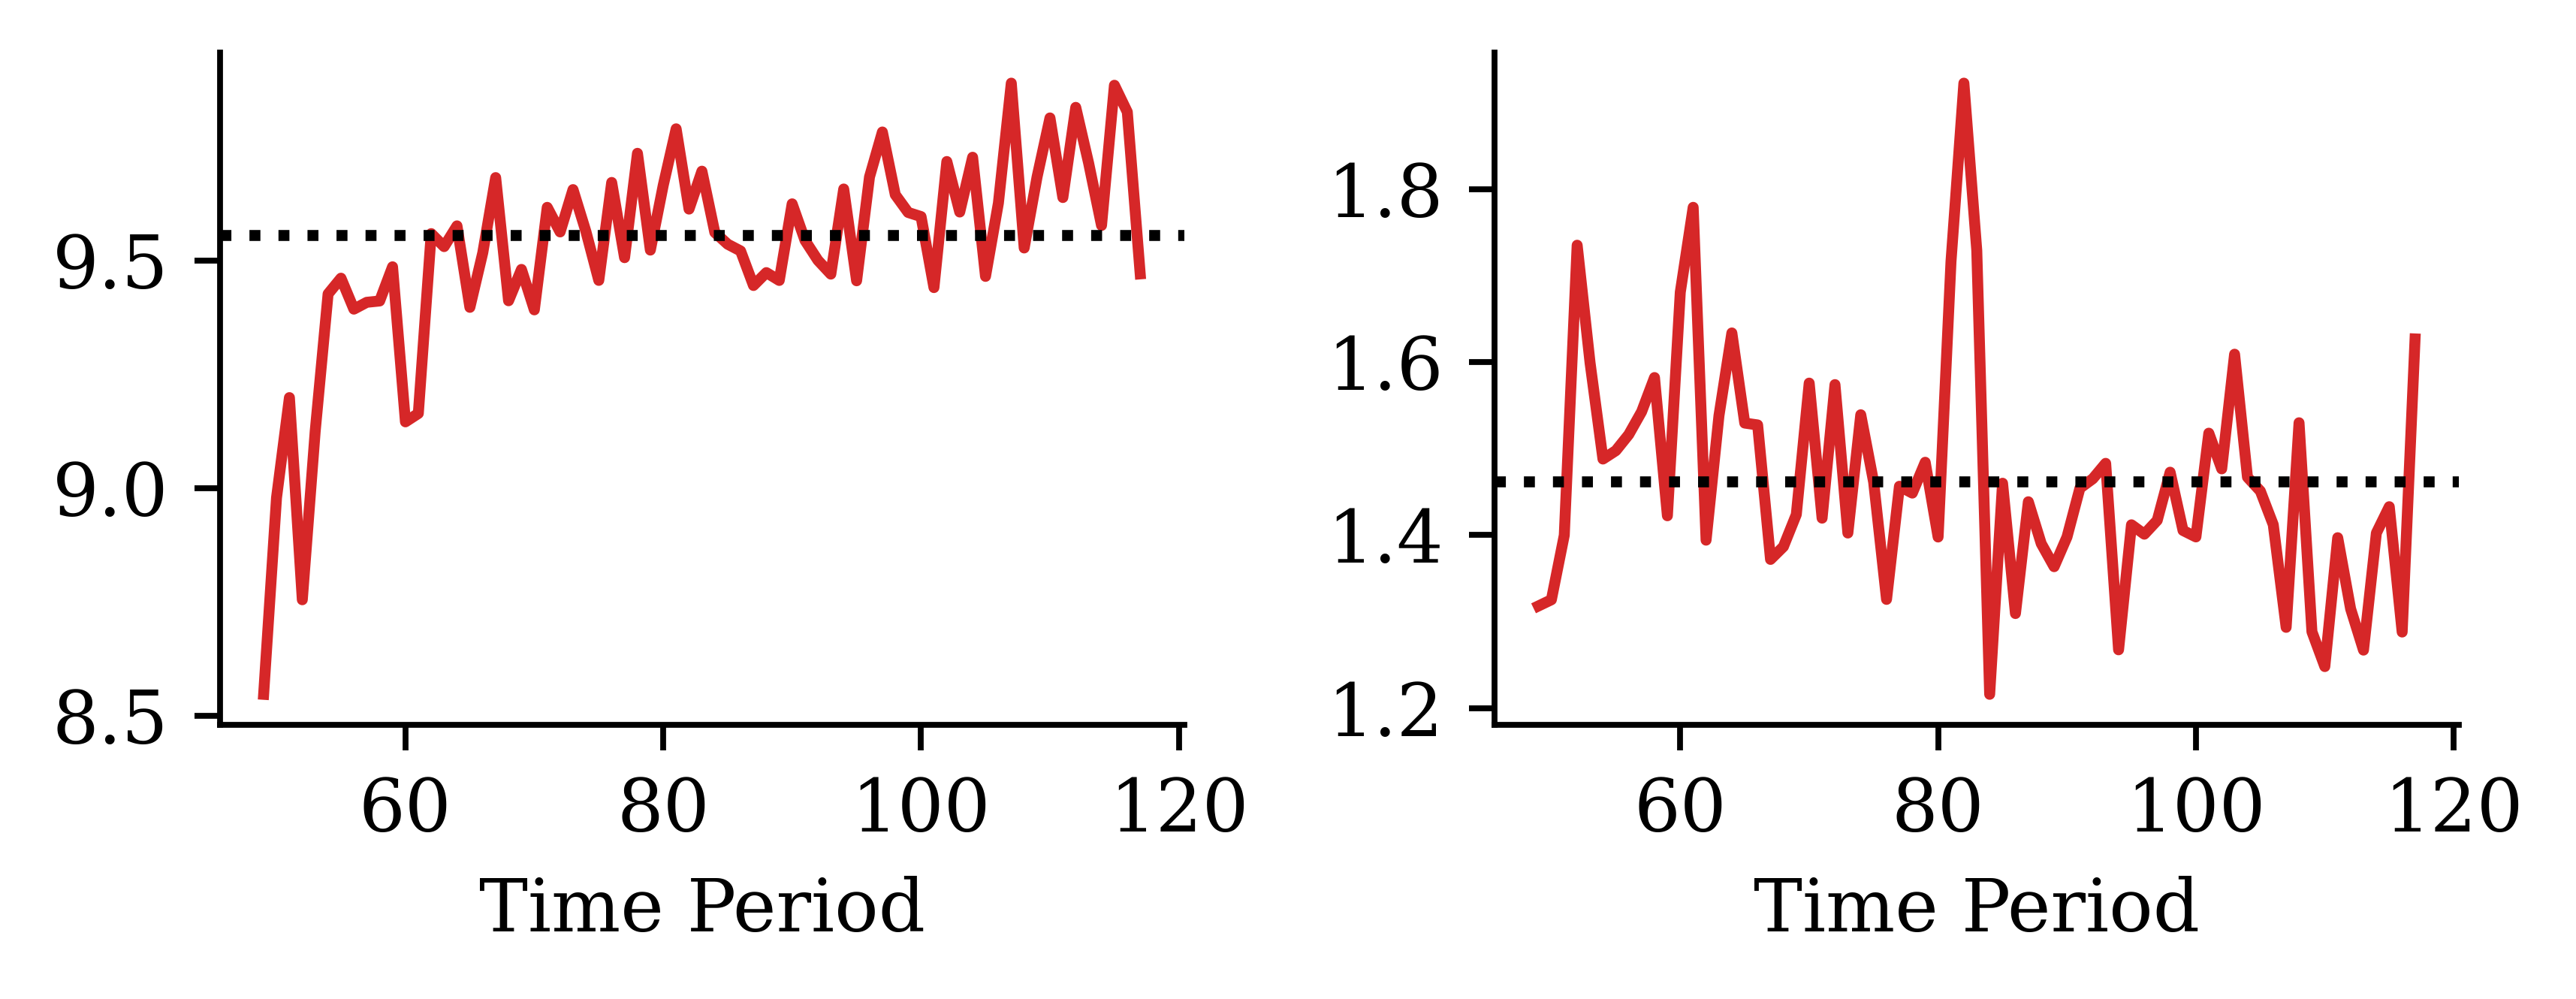

In [15]:
fig, axs = plt.subplots(1, 2, tight_layout=True)

# the histogram of the data
axs[0].plot(
    time_periods,
    mle_time_periods[mle_time_periods.model == "lognormal"].param1,
    c=lnormColor,
)
axs[0].set_xlabel("Time Period")
# axs[0].set_title("$\mu$")
axs[0].axhline(y=μ_mle, **mleStyle)
axs[1].plot(
    time_periods,
    mle_time_periods[mle_time_periods.model == "lognormal"].param2,
    c=lnormColor,
)
axs[1].set_xlabel("Time Period")
# axs[1].set_title("$\sigma$")
axs[1].axhline(y=σ_mle, **mleStyle)

sns.despine()
save_cropped("../Figures/aus-log-norm-params.pdf")

The parameters of the lognormal distribution remains reasonably stable across the time period.

Now we aggregate the data in order to have only information per time period (monthly aggregation). hereafter a short overview of the data and some descriptive stat over the number of claims and the total claim amount per time period.

In [16]:
df_agg = pd.DataFrame(
    {"N": aus.groupby(by="FinMth").size(), "X": aus.groupby(by="FinMth").AggClaim.sum()}
)

print(
    pd.concat(
        [df_agg["N"].head(), df_agg["X"].head().apply("{:.2e}".format)], axis=1
    ).to_latex()
)
print(
    pd.concat([aus["AggClaim"].describe(), df_agg.describe()], axis=1)
    .applymap("{:.2e}".format)
    .to_latex()
)
# df1 = df_agg.head(7)
# df2 = df_agg.describe()
# df1_styler = df1.style.set_table_attributes("style='display:inline'").set_caption('First 7 observations')
# df2_styler = df2.style.set_table_attributes("style='display:inline'").set_caption('Descriptive stats')
# display_html(df1_styler._repr_html_() +" "+ df2_styler._repr_html_(), raw=True)

\begin{tabular}{lrl}
\toprule
{} &    N &         X \\
FinMth &      &           \\
\midrule
49     &  149 &  1.55e+06 \\
50     &  188 &  3.21e+06 \\
51     &  196 &  4.81e+06 \\
52     &  203 &  4.22e+06 \\
53     &  226 &  5.27e+06 \\
\bottomrule
\end{tabular}

\begin{tabular}{llll}
\toprule
{} &  AggClaim &         N &         X \\
\midrule
count &  2.20e+04 &  6.90e+01 &  6.90e+01 \\
mean  &  3.84e+04 &  3.19e+02 &  1.23e+07 \\
std   &  9.10e+04 &  1.09e+02 &  5.22e+06 \\
min   &  9.96e+00 &  9.40e+01 &  1.55e+06 \\
25\%   &  6.30e+03 &  2.31e+02 &  8.21e+06 \\
50\%   &  1.39e+04 &  3.12e+02 &  1.20e+07 \\
75\%   &  3.51e+04 &  3.81e+02 &  1.55e+07 \\
max   &  4.49e+06 &  6.06e+02 &  2.63e+07 \\
\bottomrule
\end{tabular}



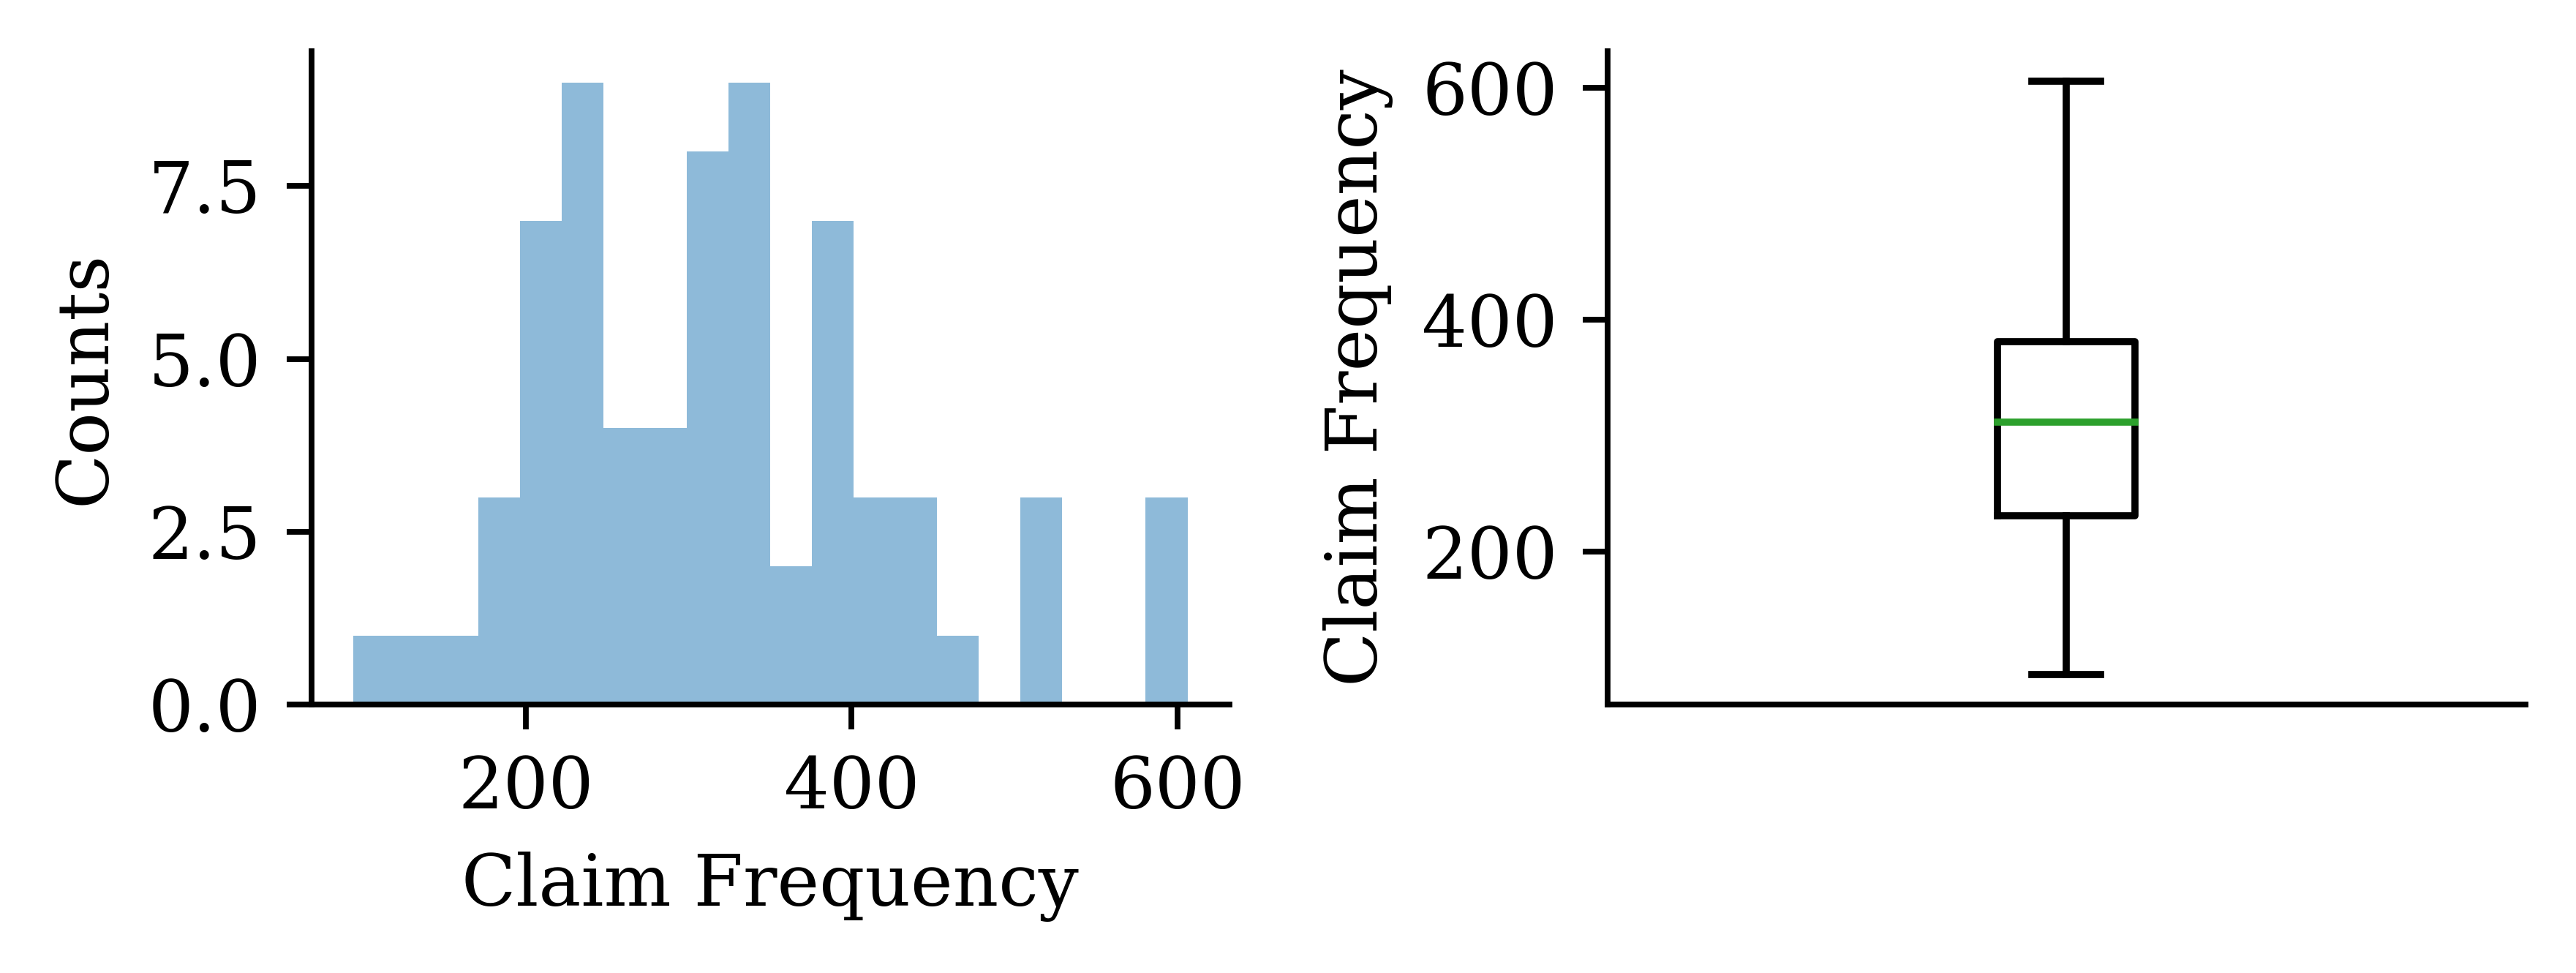

In [17]:
fig, axs = plt.subplots(1, 2, tight_layout=True)
num_bins = 20

# the histogram of the data
n, bins, patches = axs[0].hist(df_agg.N, num_bins, alpha=0.5)
axs[1].boxplot(df_agg.N)
axs[0].set_xlabel("Claim Frequency")
axs[0].set_ylabel("Counts")
axs[1].set_ylabel("Claim Frequency")
axs[1].set_xticks([])

sns.despine()
# save_cropped("../Figures/hist-box-claim-frequency.pdf")

We run a Bayesian analysis over the claim frequency, considering two models including
- Poisson
- negative binomial

In [18]:
nData = df_agg.N.values

with pm.Model() as model_negbin:
    α = pm.Uniform("α", lower=0, upper=20)
    p = pm.Uniform("p", lower=1e-3, upper=1)
    N = pm.NegativeBinomial("N", mu=α * (1 - p) / p, alpha=α, observed=nData)
    %time trace_negbin = pm.sample_smc(popSize, random_seed=1, chains=1)

post_sample_negbin = pd.DataFrame(
    {
        "model": np.repeat("negative binomial", popSize),
        "weights": np.ones(popSize) / popSize,
        "α": trace_negbin["α"],
        "p": trace_negbin["p"],
    }
)

with pm.Model() as model_poisson:
    λ = pm.Uniform("λ", lower=300, upper=350)
    N = pm.Poisson("N", mu=λ, observed=nData)
    %time trace_poisson = pm.sample_smc(popSize, random_seed=1, chains=1)

post_sample_poisson = pd.DataFrame(
    {
        "model": np.repeat("poisson", popSize),
        "weights": np.ones(popSize) / popSize,
        "λ": trace_poisson["λ"],
    }
)

Initializing SMC sampler...
Sampling 1 chain in 1 job
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.001
Stage:   2 Beta: 0.004
Stage:   3 Beta: 0.026
Stage:   4 Beta: 0.140
Stage:   5 Beta: 0.470
Stage:   6 Beta: 1.000


CPU times: user 1.79 s, sys: 329 ms, total: 2.12 s
Wall time: 10.9 s


Initializing SMC sampler...
Sampling 1 chain in 1 job
Stage:   0 Beta: 0.092
Stage:   1 Beta: 0.673
Stage:   2 Beta: 1.000


CPU times: user 590 ms, sys: 87.8 ms, total: 678 ms
Wall time: 3.32 s


In [19]:
marginal_likelihood = np.exp(
    np.array(
        [
            trace_negbin.report.log_marginal_likelihood[0],
            trace_poisson.report.log_marginal_likelihood[0],
        ]
    )
)
BF = marginal_likelihood / np.max(marginal_likelihood)
Bayesian_summary = pd.DataFrame(
    {
        "models": ["negative binomial", "poisson"],
        "param1": [post_sample_negbin["α"].mean(), post_sample_poisson["λ"].mean()],
        "param2": [post_sample_negbin["p"].mean(), None],
        "BF": BF,
        "model_prob": BF / np.sum(BF),
    }
)

We consider the MLE of the lognormal distribution and the map of the negative binomial distribution as the target parameters. 

In [20]:
θ_mle = np.array(
    [
        [
            post_sample_negbin["α"].mean(),
            post_sample_negbin["p"].mean(),
            μ_mle[0],
            σ_mle[0],
        ],
        [
            post_sample_negbin["α"].mean(),
            post_sample_negbin["p"].mean(),
            α_mle[0],
            β_mle[0],
        ],
        [
            post_sample_negbin["α"].mean(),
            post_sample_negbin["p"].mean(),
            k_mle[0],
            δ_mle[0],
        ],
    ]
)

We will now use ABC on the aggregate data to fit a compound 

- negative binomial-lognormal

We start by the first data regime where we do not know anything about the claim frequency. We only consider the aggregated data. 

Let us start by infer the negative binomial lognormal model

In [21]:
params = ("α", "p", "μ", "σ")

In [22]:
psi = abc.Psi("sum")

In [23]:
lame_prior = abc.IndependentUniformPrior(((0, 20), (1e-3, 1), (0, 20), (0, 10)), params)
great_prior = abc.IndependentUniformPrior(
    ((0, 20), (1e-3, 1), (-10, 10), (0, 10)), params
)

model_lame = abc.Model("negative binomial", "lognormal", psi, lame_prior)
model_great = abc.Model("negative binomial", "lognormal", psi, great_prior)

xData = df_agg.X.values

%time fit_lame = abc.smc(numIters, popSize, xData, model_lame, **smcArgs)
%time fit_great = abc.smc(numIters, popSize, xData, model_great, **smcArgs)

abc_sample_lame_prior = pd.DataFrame(
    {
        "prior": np.repeat("lame", popSize),
        "model_freq": np.repeat("negative binomial", popSize),
        "model_sev": np.repeat("lognormal", popSize),
        "weights": fit_lame.weights,
        "α": fit_lame.samples[:, 0],
        "p": fit_lame.samples[:, 1],
        "μ": fit_lame.samples[:, 2],
        "σ": fit_lame.samples[:, 3],
    }
)

abc_sample_great_prior = pd.DataFrame(
    {
        "prior": np.repeat("great", popSize),
        "model_freq": np.repeat("negative binomial", popSize),
        "model_sev": np.repeat("lognormal", popSize),
        "weights": fit_great.weights,
        "α": fit_great.samples[:, 0],
        "p": fit_great.samples[:, 1],
        "μ": fit_great.samples[:, 2],
        "σ": fit_great.samples[:, 3],
    }
)
abc_sample_nb_lnorm = pd.concat([abc_sample_lame_prior, abc_sample_great_prior], axis=0)

abc_sample_nb_lnorm

Final population dists <= 499653.24, ESS = 808
CPU times: user 16.3 s, sys: 2.11 s, total: 18.4 s
Wall time: 25.7 s


Final population dists <= 663656.72, ESS = 631
CPU times: user 16 s, sys: 1.36 s, total: 17.4 s
Wall time: 32.4 s


,prior,model_freq,model_sev,weights,α,p,μ,σ
0,lame,negative binomial,lognormal,0.000753,12.125346,0.396810,12.926701,0.978827
1,lame,negative binomial,lognormal,0.000675,14.335512,0.499927,13.613936,0.391701
2,lame,negative binomial,lognormal,0.000680,11.676692,0.503318,13.777620,0.474063
3,lame,negative binomial,lognormal,0.000687,14.298931,0.427821,12.819710,0.964701
4,lame,negative binomial,lognormal,0.000972,9.804320,0.230045,12.069442,1.222257
...,...,...,...,...,...,...,...,...
995,great,negative binomial,lognormal,0.000701,10.879515,0.038264,8.477540,2.179940
996,great,negative binomial,lognormal,0.000674,7.580921,0.030736,9.631768,1.549183
997,great,negative binomial,lognormal,0.001160,13.683801,0.041066,7.319431,2.652075
998,great,negative binomial,lognormal,0.000637,11.023702,0.041237,8.962775,1.944502


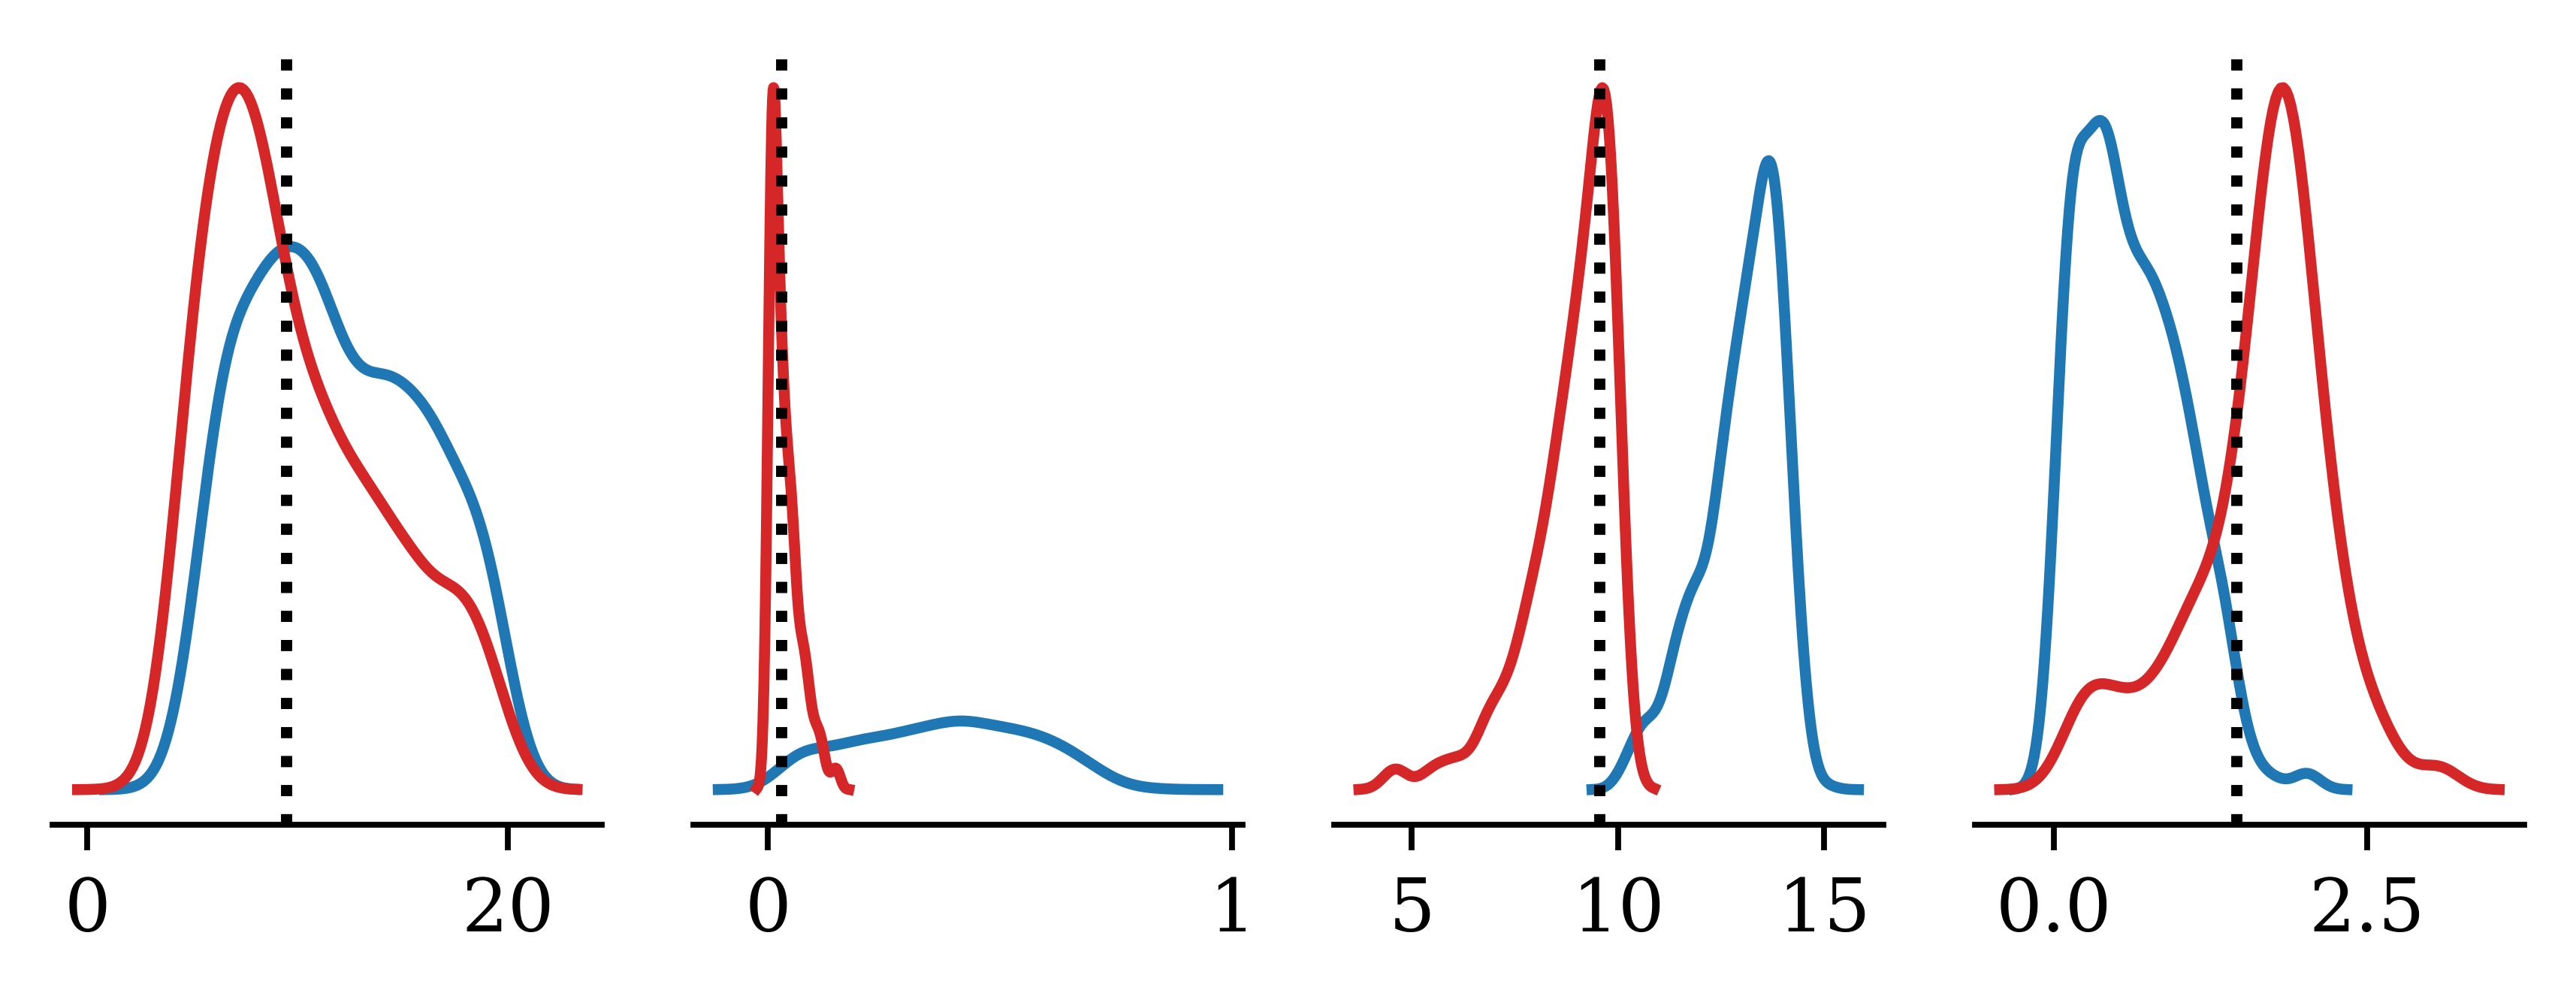

In [24]:
# Histograms of the parammeters of the negative binomial distribution
prior_names = ["lame", "great"]
# prior_colors = ["tab:olive", "tab:brown"]
prior_colors = [colors[0], colors[2]]

fig, axs = plt.subplots(1, len(params), tight_layout=True)
linestyles = ["solid", "solid"]

for l in range(len(params)):
    for k in range(len(prior_names)):
        sample = abc_sample_nb_lnorm[abc_sample_nb_lnorm.prior == prior_names[k]][
            params[l]
        ]
        weights = abc_sample_nb_lnorm[abc_sample_nb_lnorm.prior == prior_names[k]][
            "weights"
        ]
        dataResampled, xs, ys = abc.resample_and_kde(sample, weights)
        axs[l].plot(xs, ys, color=prior_colors[k], linestyle=linestyles[k])
        axs[l].axvline(θ_mle[0, l], **mleStyle)
        # axs[l].set_title("$" + params[l] + "$")
        axs[l].set_yticks([])

sns.despine(left=True)
save_cropped("../Figures/hist-RD-negbin-lognormal-priors.pdf")

Hereafter is the ABC posterior of the negative binomial parameters $\alpha$ and $p$.

In [25]:
params = ("μ", "σ")

In [26]:
lame_prior = abc.IndependentUniformPrior(((0, 20), (0, 10)), ("μ", "σ"))
great_prior = abc.IndependentUniformPrior(((-10, 10), (0, 10)), ("μ", "σ"))

xData = df_agg.X.values
nData = df_agg.N.values

model_lame = abc.Model(nData, "lognormal", psi, lame_prior)
model_great = abc.Model(nData, "lognormal", psi, great_prior)

%time fit_lame = abc.smc(numItersData, popSize, xData, model_lame, **smcArgs)
%time fit_great = abc.smc(numItersData, popSize, xData, model_great, **smcArgs)

abc_sample_lame_prior = pd.DataFrame(
    {
        "prior": np.repeat("lame", popSize),
        "model_freq": np.repeat("With Frequencies", popSize),
        "model_sev": np.repeat("lognormal", popSize),
        "weights": fit_lame.weights,
        "μ": fit_lame.samples[:, 0],
        "σ": fit_lame.samples[:, 1],
    }
)

abc_sample_great_prior = pd.DataFrame(
    {
        "prior": np.repeat("great", popSize),
        "model_freq": np.repeat("With Frequencies", popSize),
        "model_sev": np.repeat("lognormal", popSize),
        "weights": fit_great.weights,
        "μ": fit_great.samples[:, 0],
        "σ": fit_great.samples[:, 1],
    }
)

abc_sample_freqs_lnorm = pd.concat(
    [abc_sample_lame_prior, abc_sample_great_prior], axis=0
)
abc_sample_freqs_lnorm

Final population dists <= 318512.20, ESS = 863
CPU times: user 23.5 s, sys: 1.87 s, total: 25.4 s
Wall time: 33min 1s


Final population dists <= 306550.83, ESS = 853
CPU times: user 25.5 s, sys: 2.25 s, total: 27.8 s
Wall time: 1h 5min 15s


,prior,model_freq,model_sev,weights,μ,σ
0,lame,With Frequencies,lognormal,0.001173,8.348356,2.108109
1,lame,With Frequencies,lognormal,0.000750,8.639693,1.968210
2,lame,With Frequencies,lognormal,0.000751,8.697456,1.928712
3,lame,With Frequencies,lognormal,0.000911,8.772047,1.873078
4,lame,With Frequencies,lognormal,0.001002,9.044743,1.729617
...,...,...,...,...,...,...
995,great,With Frequencies,lognormal,0.001435,8.334296,2.104576
996,great,With Frequencies,lognormal,0.007442,7.922558,2.304936
997,great,With Frequencies,lognormal,0.000816,8.859279,1.856287
998,great,With Frequencies,lognormal,0.001040,8.378568,2.122722


Let us generate the posterior sample of the lognormal distribution when we have the claim frequency data.

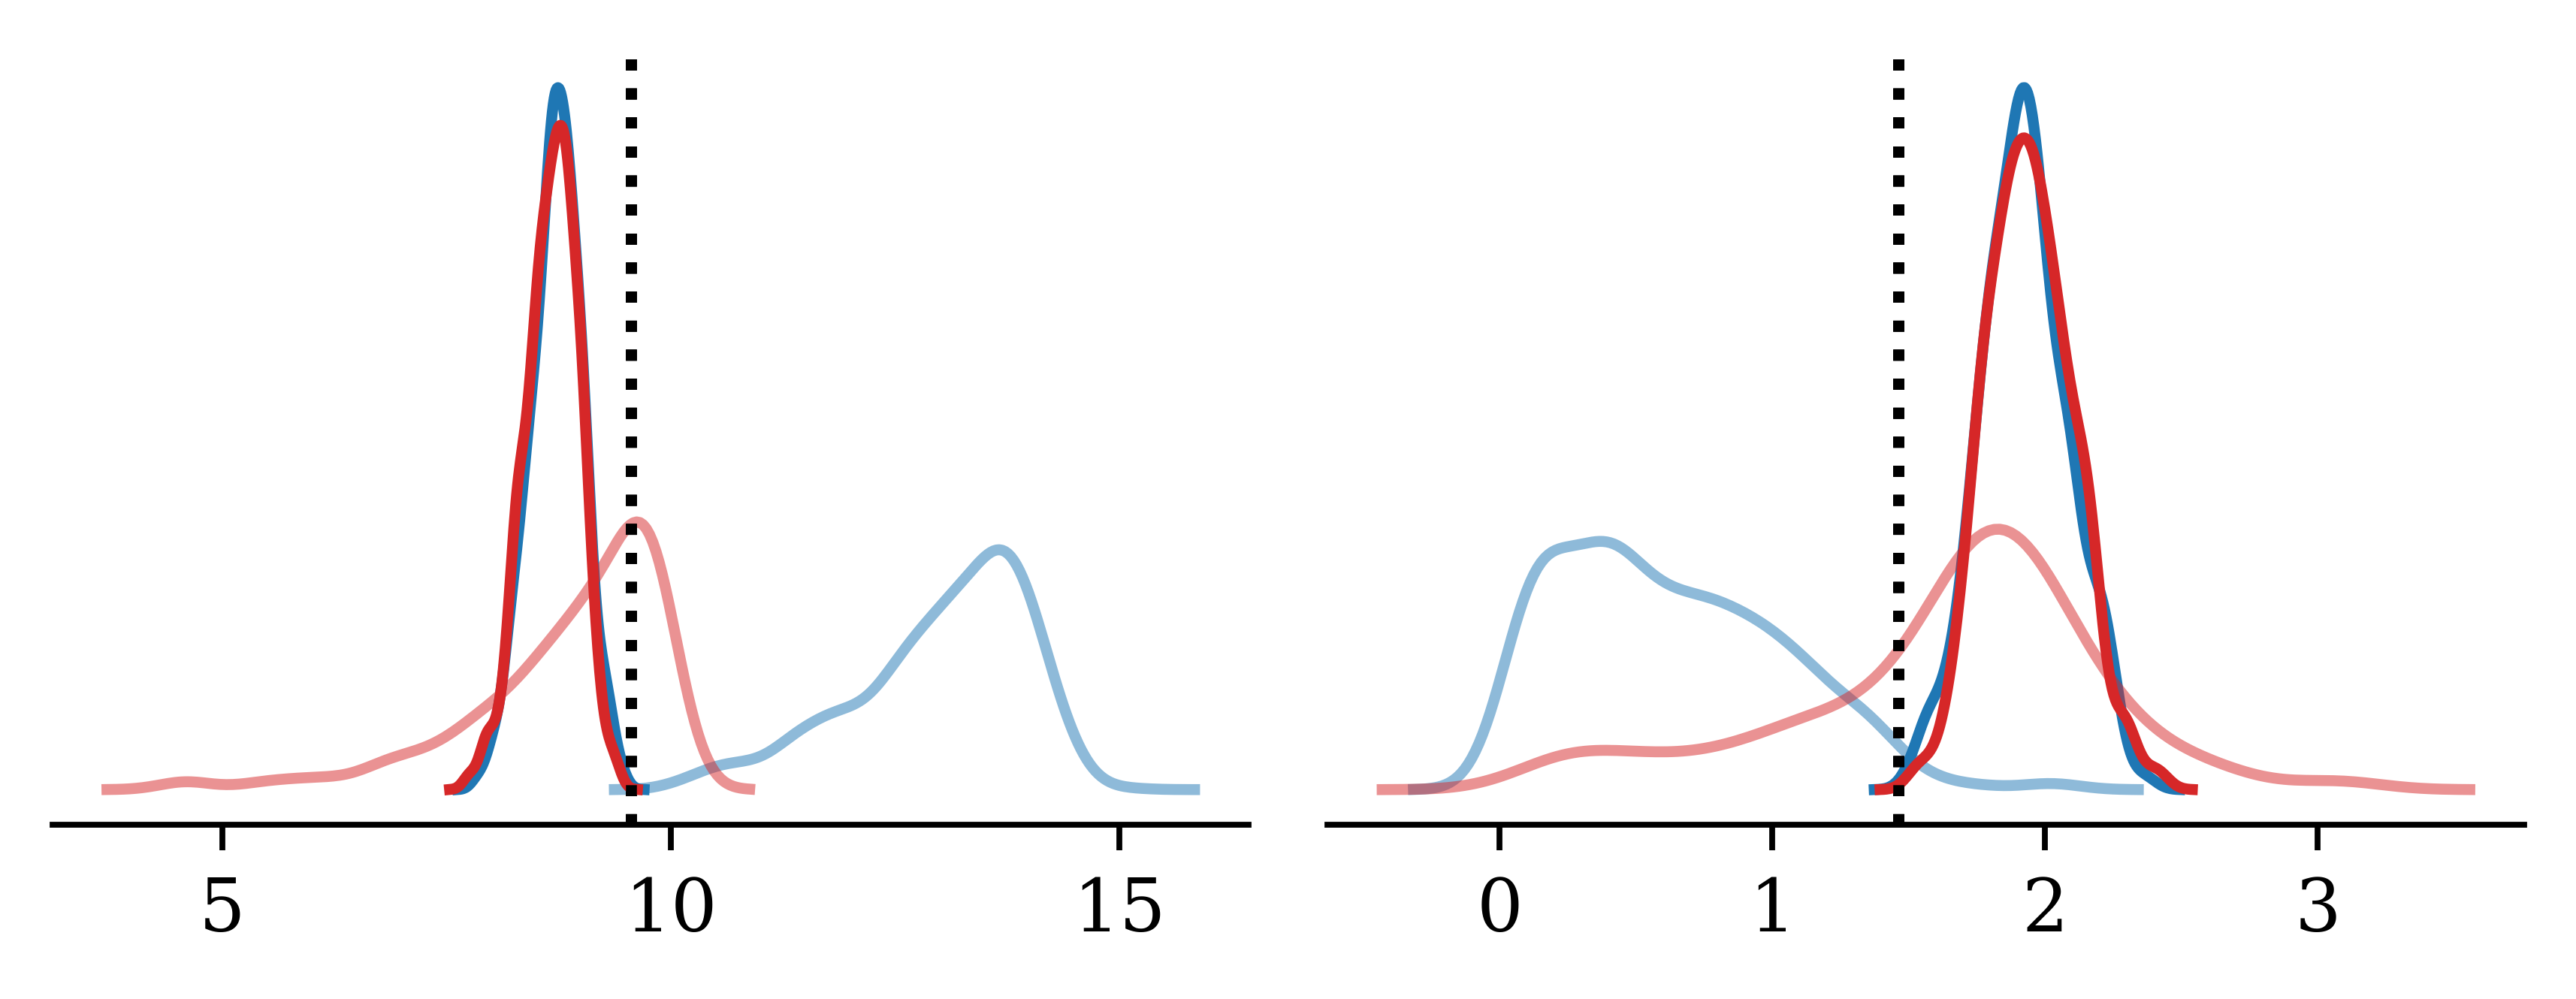

In [27]:
# Histograms of the parameters of the negative binomial distribution
abc_sample_lnorm = pd.concat(
    [
        abc_sample_nb_lnorm[["prior", "model_freq", "model_sev", "weights", "μ", "σ"]],
        abc_sample_freqs_lnorm,
    ]
)

prior_names = ["lame", "great"]
freq_models = ["negative binomial", "With Frequencies"]
alphas = [0.5, 1]

fig, axs = plt.subplots(1, len(params), tight_layout=True)

for l in range(len(params)):
    for k in range(len(prior_names)):
        for i in range(len(freq_models)):
            selector = (abc_sample_lnorm.model_freq == freq_models[i]) & (
                abc_sample_lnorm.prior == prior_names[k]
            )
            sample = abc_sample_lnorm[selector][params[l]]
            weights = abc_sample_lnorm[selector]["weights"]

            dataResampled, xs, ys = abc.resample_and_kde(sample, weights)
            axs[l].plot(xs, ys, color=prior_colors[k], alpha=alphas[i])
            axs[l].axvline(θ_mle[0, l + 2], **mleStyle)
            # axs[l].set_title("$"+ params[l] + "$")
            axs[l].set_yticks([])

sns.despine(left=True)
save_cropped("../Figures/hist-RD-freq-lognormal-priors.pdf")

In [28]:
params = [("α", "p", "μ", "σ"), ("α", "p", "r", "m"), ("α", "p", "k", "β")]

In [29]:
xData = df_agg.X.values
nData = df_agg.N.values

prior1 = abc.IndependentUniformPrior(
    [(0, 20), (1e-3, 1), (5, 10), (0, 3)], ("α", "p", "μ", "σ")
)
model1 = abc.Model("negative binomial", "lognormal", psi, prior1)

prior2 = abc.IndependentUniformPrior(
    [(0, 20), (1e-3, 1), (0, 100), (0, 150000)], ("α", "p", "r", "m")
)
model2 = abc.Model("negative binomial", "gamma", psi, prior2)

prior3 = abc.IndependentUniformPrior(
    [(0, 20), (1e-3, 1), (1e-3, 1), (0, 40000)], ("α", "p", "k", "β")
)
model3 = abc.Model("negative binomial", "weibull", psi, prior3)

models = [model1, model2, model3]

sev_models = ["lognormal", "gamma", "weibull"]

abc_model_prob_nb = pd.DataFrame(
    {"model_freq": [], "model_sev": [], "model_probability": []}
)
abc_model_sample_nb = pd.DataFrame(
    {
        "model_freq": [],
        "model_sev": [],
        "weights": [],
        "α": [],
        "p": [],
        "param1": [],
        "param2": [],
    }
)

%time fit = abc.smc(10, popSize, xData, models, **smcArgs)

for k in range(len(sev_models)):
    weights = fit.weights[fit.models == k]
    res_mp = pd.DataFrame(
        {
            "model_freq": pd.Series(["negative binomial"]),
            "model_sev": pd.Series([sev_models[k]]),
            "model_probability": pd.Series(np.sum(fit.weights[fit.models == k])),
        }
    )

    abc_model_prob_nb = pd.concat([abc_model_prob_nb, res_mp])

    res_post_samples = pd.DataFrame(
        {
            "model_freq": np.repeat("negative binomial", len(weights)),
            "model_sev": np.ravel(np.repeat(sev_models[k], len(weights))),
            "weights": weights / np.sum(weights),
            "α": np.array(fit.samples)[fit.models == k, 0],
            "p": np.array(fit.samples)[fit.models == k, 1],
            "param1": np.array(fit.samples)[fit.models == k, 2],
            "param2": np.array(fit.samples)[fit.models == k, 3],
        }
    )
    abc_model_sample_nb = pd.concat([abc_model_sample_nb, res_post_samples])

Final population dists <= 574144.59, ESS = [ 35 372 258]
	model populations = [110, 493, 397], model weights = [0.02 0.89 0.09]
CPU times: user 14.2 s, sys: 1.31 s, total: 15.5 s
Wall time: 27.8 s


In [30]:
xData = df_agg.X.values
nData = df_agg.N.values

prior1 = abc.IndependentUniformPrior(
    [(0, 20), (1e-3, 1), (5, 10), (0, 3)], ("α", "p", "μ", "σ")
)
model1 = abc.Model("negative binomial", "lognormal", psi, prior1)

prior2 = abc.IndependentUniformPrior(
    [(0, 20), (1e-3, 1), (0, 100), (0, 150000)], ("α", "p", "r", "m")
)
model2 = abc.Model("negative binomial", "gamma", psi, prior2)

prior3 = abc.IndependentUniformPrior(
    [(0, 20), (1e-3, 1), (1e-3, 1), (0, 40000)], ("α", "p", "k", "β")
)
model3 = abc.Model("negative binomial", "weibull", psi, prior3)

models = [model1, model2, model3]

sev_models = ["lognormal", "gamma", "weibull"]

abc_model_prob_nb = pd.DataFrame(
    {"model_freq": [], "model_sev": [], "model_probability": []}
)
abc_model_sample_nb = pd.DataFrame(
    {
        "model_freq": [],
        "model_sev": [],
        "weights": [],
        "α": [],
        "p": [],
        "param1": [],
        "param2": [],
    }
)

%time fit = abc.smc(numIters, popSizeModels, xData, models, **smcArgs)

for k in range(len(sev_models)):
    weights = fit.weights[fit.models == k]
    res_mp = pd.DataFrame(
        {
            "model_freq": pd.Series(["negative binomial"]),
            "model_sev": pd.Series([sev_models[k]]),
            "model_probability": pd.Series(np.sum(fit.weights[fit.models == k])),
        }
    )

    abc_model_prob_nb = pd.concat([abc_model_prob_nb, res_mp])

    res_post_samples = pd.DataFrame(
        {
            "model_freq": np.repeat("negative binomial", len(weights)),
            "model_sev": np.ravel(np.repeat(sev_models[k], len(weights))),
            "weights": weights / np.sum(weights),
            "α": np.array(fit.samples)[fit.models == k, 0],
            "p": np.array(fit.samples)[fit.models == k, 1],
            "param1": np.array(fit.samples)[fit.models == k, 2],
            "param2": np.array(fit.samples)[fit.models == k, 3],
        }
    )
    abc_model_sample_nb = pd.concat([abc_model_sample_nb, res_post_samples])

Final population dists <= 406841.29, ESS = [ 24 286  37]
	model populations = [139, 521, 340], model weights = [0.02 0.91 0.07]
CPU times: user 24.5 s, sys: 1.58 s, total: 26.1 s
Wall time: 5min 31s


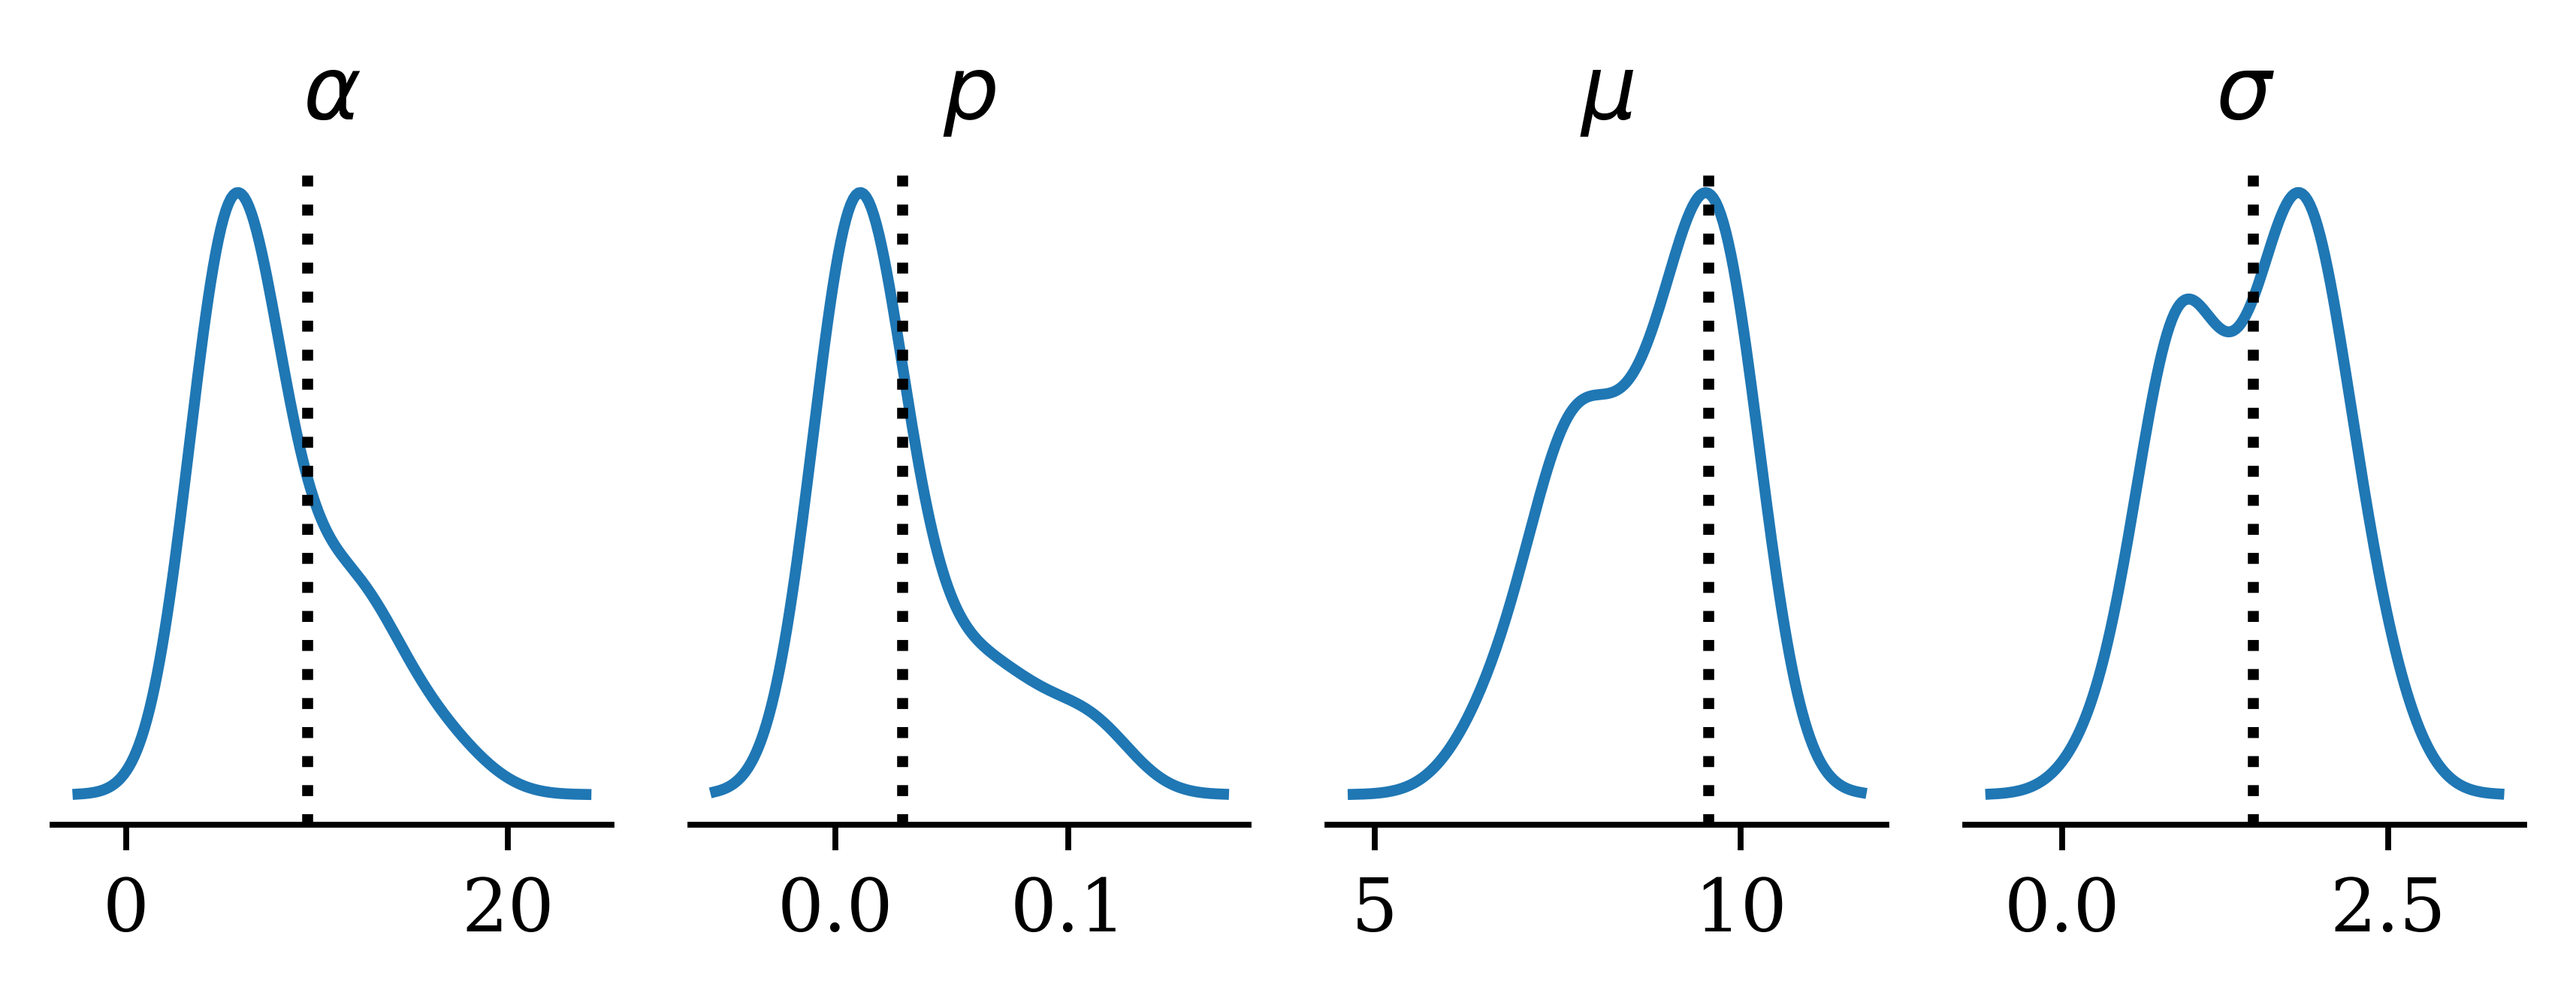

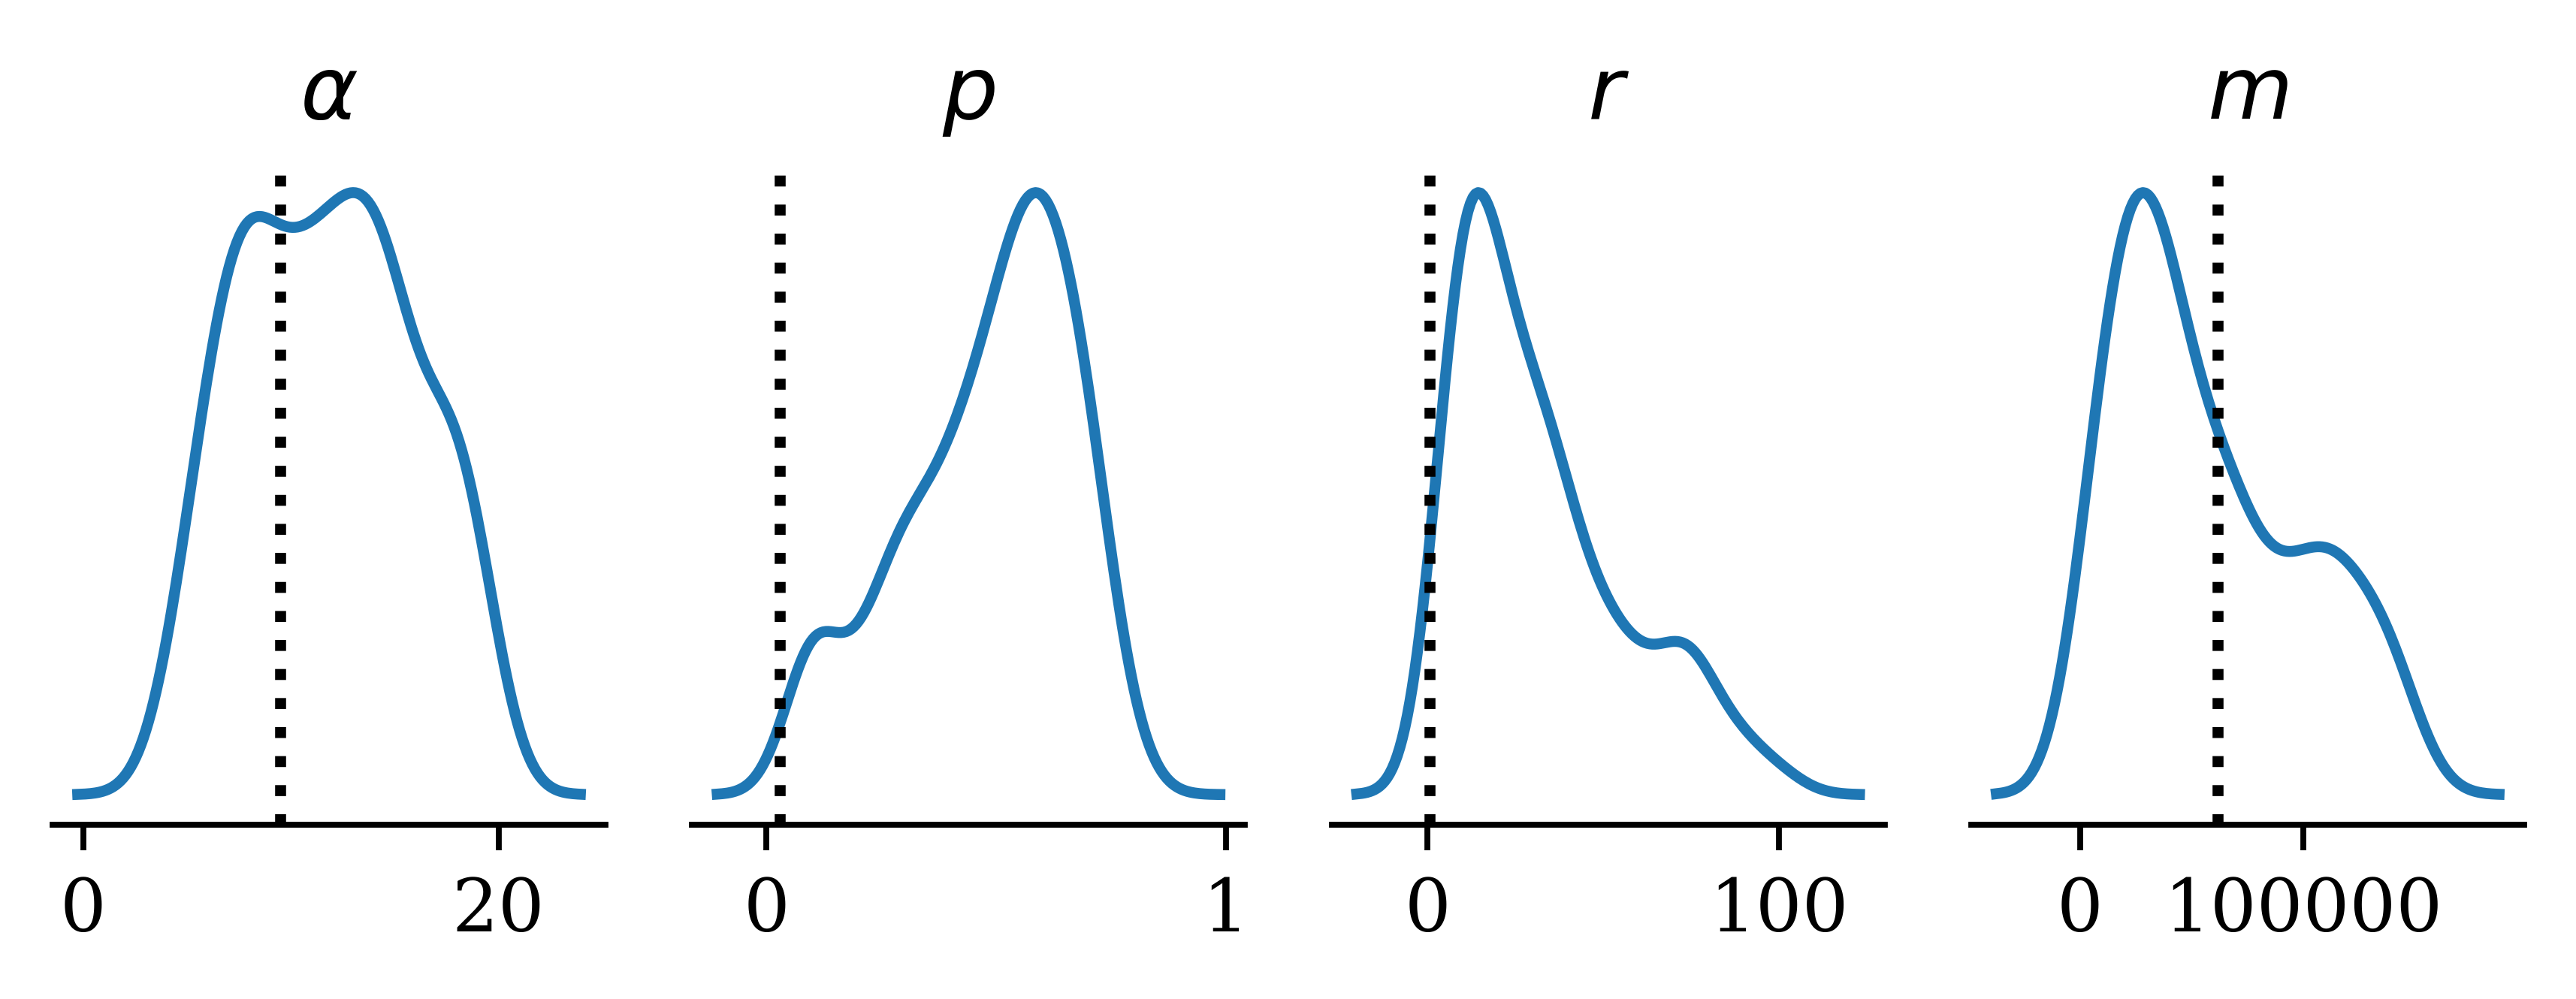

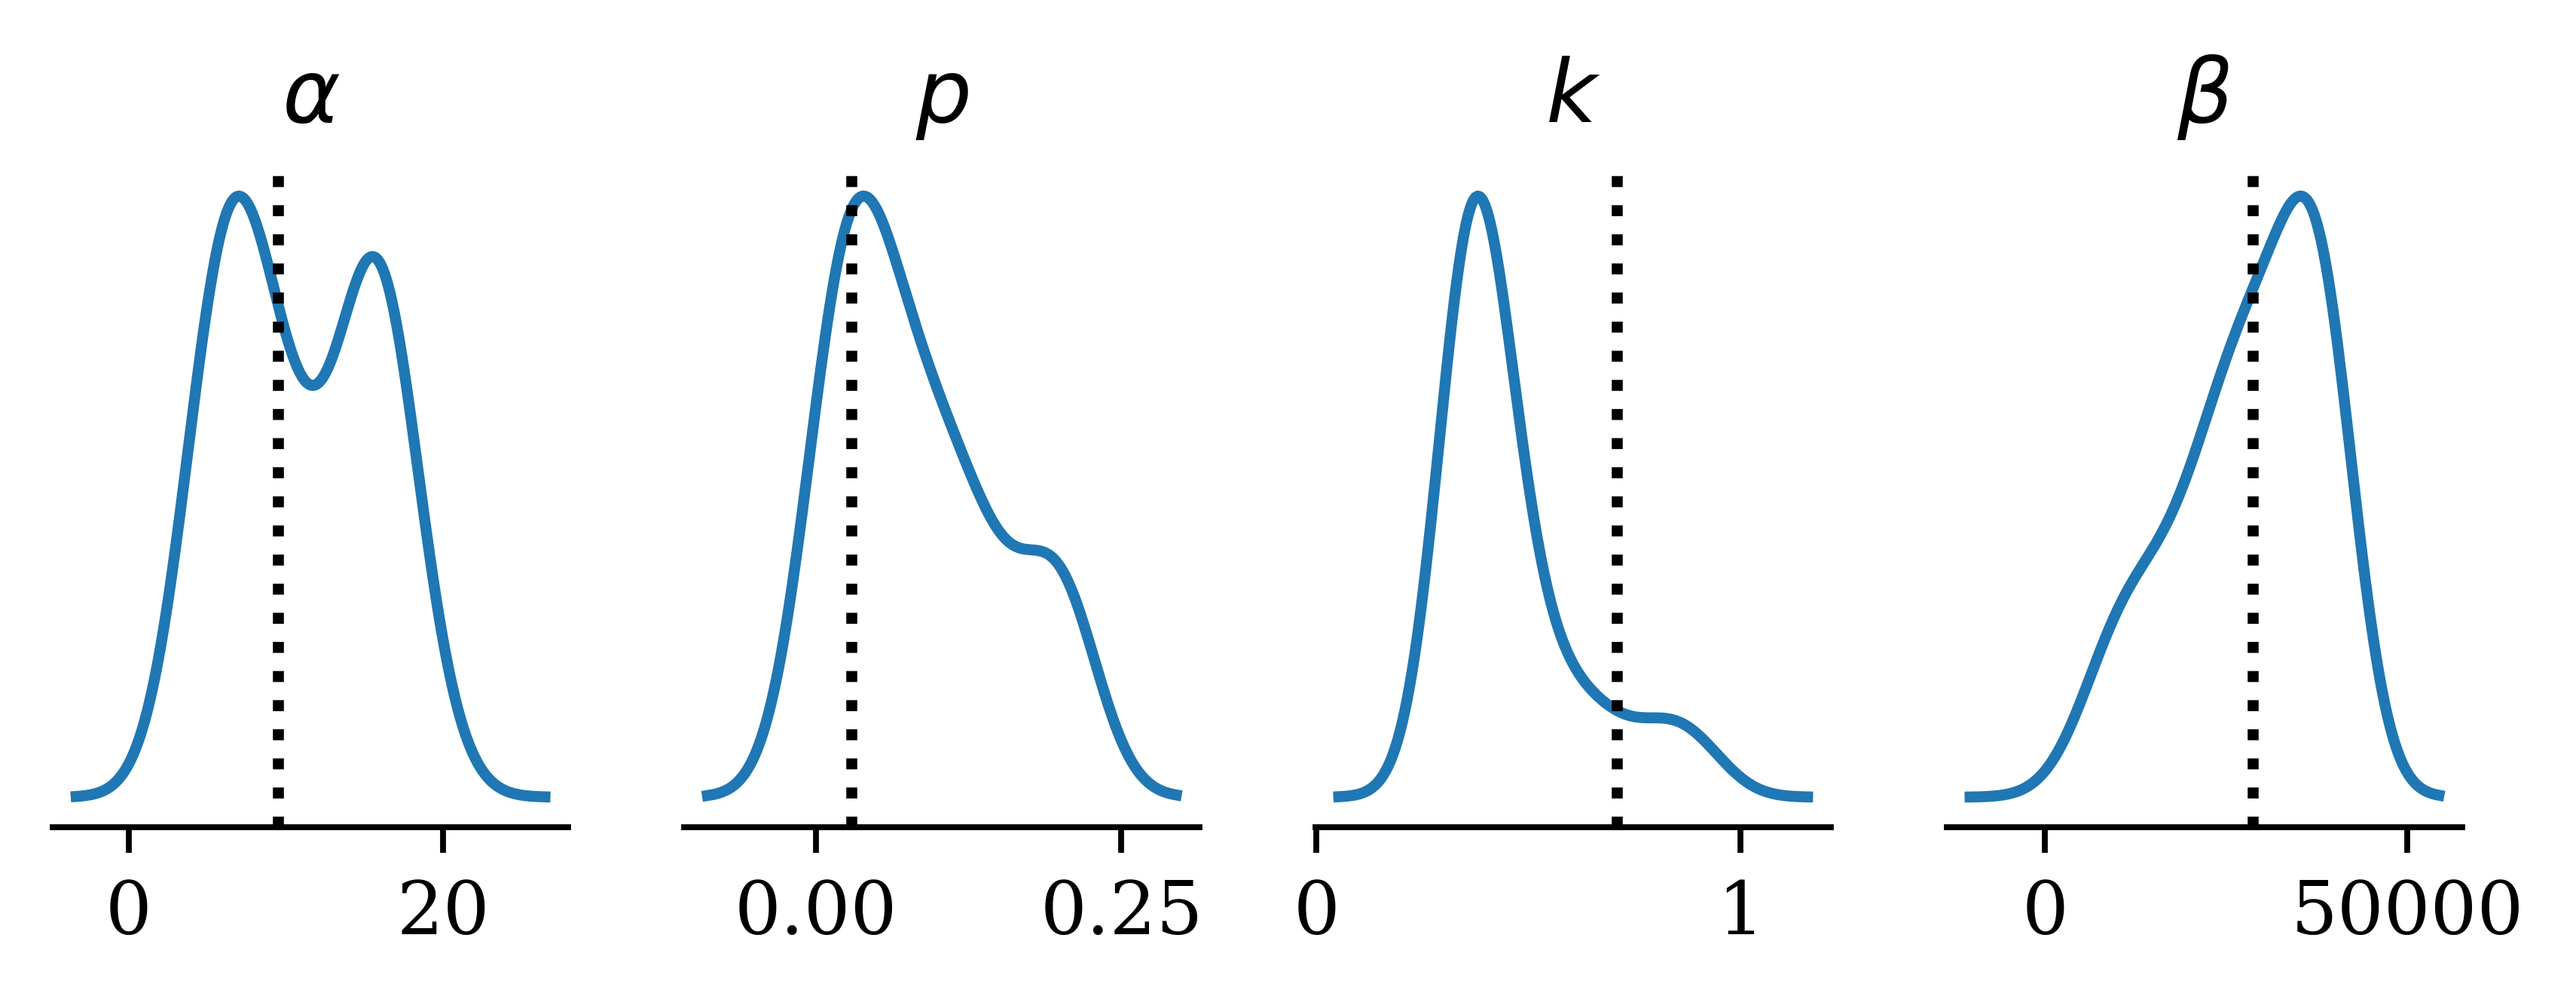

In [31]:
sev_models = ["lognormal", "gamma", "weibull"]

for l in range(len(sev_models)):
    fig, axs = plt.subplots(1, max(len(p) for p in params), tight_layout=True)

    for k in range(len(params[l])):
        selector = abc_model_sample_nb.model_sev == sev_models[l]
        sample = np.array(abc_model_sample_nb[["α", "p", "param1", "param2"]])[
            selector, k
        ]
        weights = abc_model_sample_nb.weights[selector].values
        if sum(weights) > 0:
            abc.weighted_distplot(sample, weights / sum(weights), ax=axs[k], hist=False)

        axs[k].axvline(θ_mle[l, k], **mleStyle)
        axs[k].set_title("$" + params[l][k] + "$")
        axs[k].set_yticks([])

    sns.despine(left=True)
    # save_cropped(f"../Figures/hist-RD-model-selection-{l}.pdf")

In [32]:
xData = df_agg.X.values
nData = df_agg.N.values

prior1 = abc.IndependentUniformPrior([(5, 10), (0, 3)], ("μ", "σ"))
model1 = abc.Model(nData, "lognormal", psi, prior1)

prior2 = abc.IndependentUniformPrior([(0, 100), (0, 150000)], ("r", "m"))
model2 = abc.Model(nData, "gamma", psi, prior2)

prior3 = abc.IndependentUniformPrior([(0, 1), (0, 40000)], ("k", "β"))
model3 = abc.Model(nData, "weibull", psi, prior3)

models = [model1, model2, model3]

sev_models = ["lognormal", "gamma", "weibull"]

abc_model_prob_freqs = pd.DataFrame(
    {"model_freq": [], "model_sev": [], "model_probability": []}
)
abc_model_sample_freqs = pd.DataFrame(
    {"model_freq": [], "model_sev": [], "weights": [], "param1": [], "param2": []}
)


%time fit = abc.smc(numItersData, popSizeModels, xData, models, **smcArgs)

for k in range(len(sev_models)):
    weights = fit.weights[fit.models == k]
    res_mp = pd.DataFrame(
        {
            "model_freq": pd.Series(["With Frequencies"]),
            "model_sev": pd.Series([sev_models[k]]),
            "model_probability": pd.Series(np.sum(fit.weights[fit.models == k])),
        }
    )

    abc_model_prob_freqs = pd.concat([abc_model_prob_freqs, res_mp])

    res_post_samples = pd.DataFrame(
        {
            "model_freq": np.repeat("With Frequencies", len(weights)),
            "model_sev": np.ravel(np.repeat(sev_models[k], len(weights))),
            "weights": weights / np.sum(weights),
            "param1": np.array(fit.samples)[fit.models == k, 0],
            "param2": np.array(fit.samples)[fit.models == k, 1],
        }
    )
    abc_model_sample_freqs = pd.concat([abc_model_sample_freqs, res_post_samples])

/home/plaub/miniconda3/lib/python3.8/site-packages/approxbayescomp/smc.py:371: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(weights[ms == m]) ** 2


Final population dists <= 302429.37, ESS = [294   0 590]
	model populations = [328, 0, 672], model weights = [0.47 0.   0.53]
CPU times: user 29.4 s, sys: 2.2 s, total: 31.6 s
Wall time: 1h 15min 25s


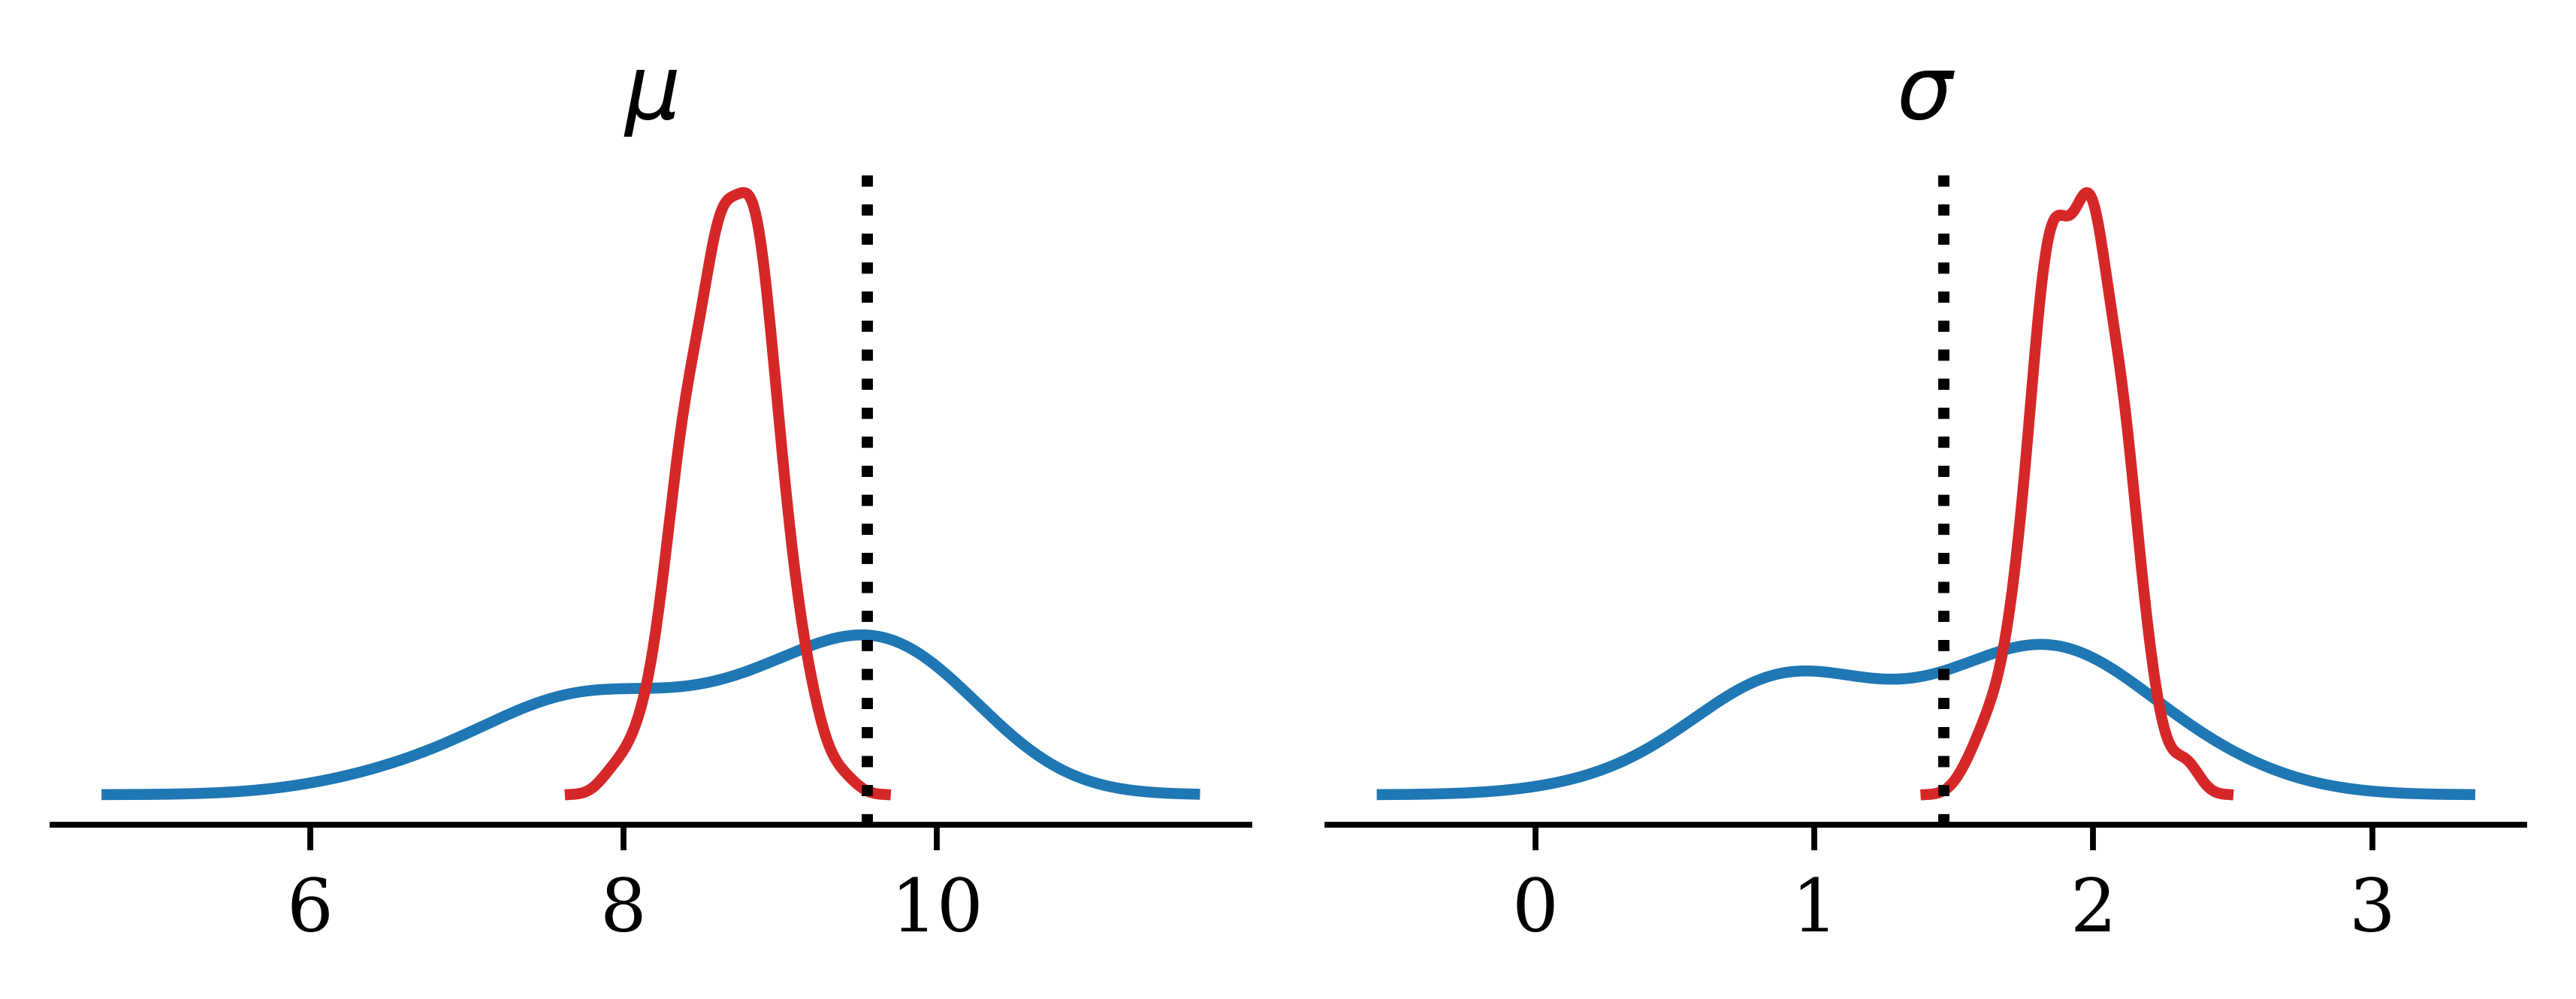

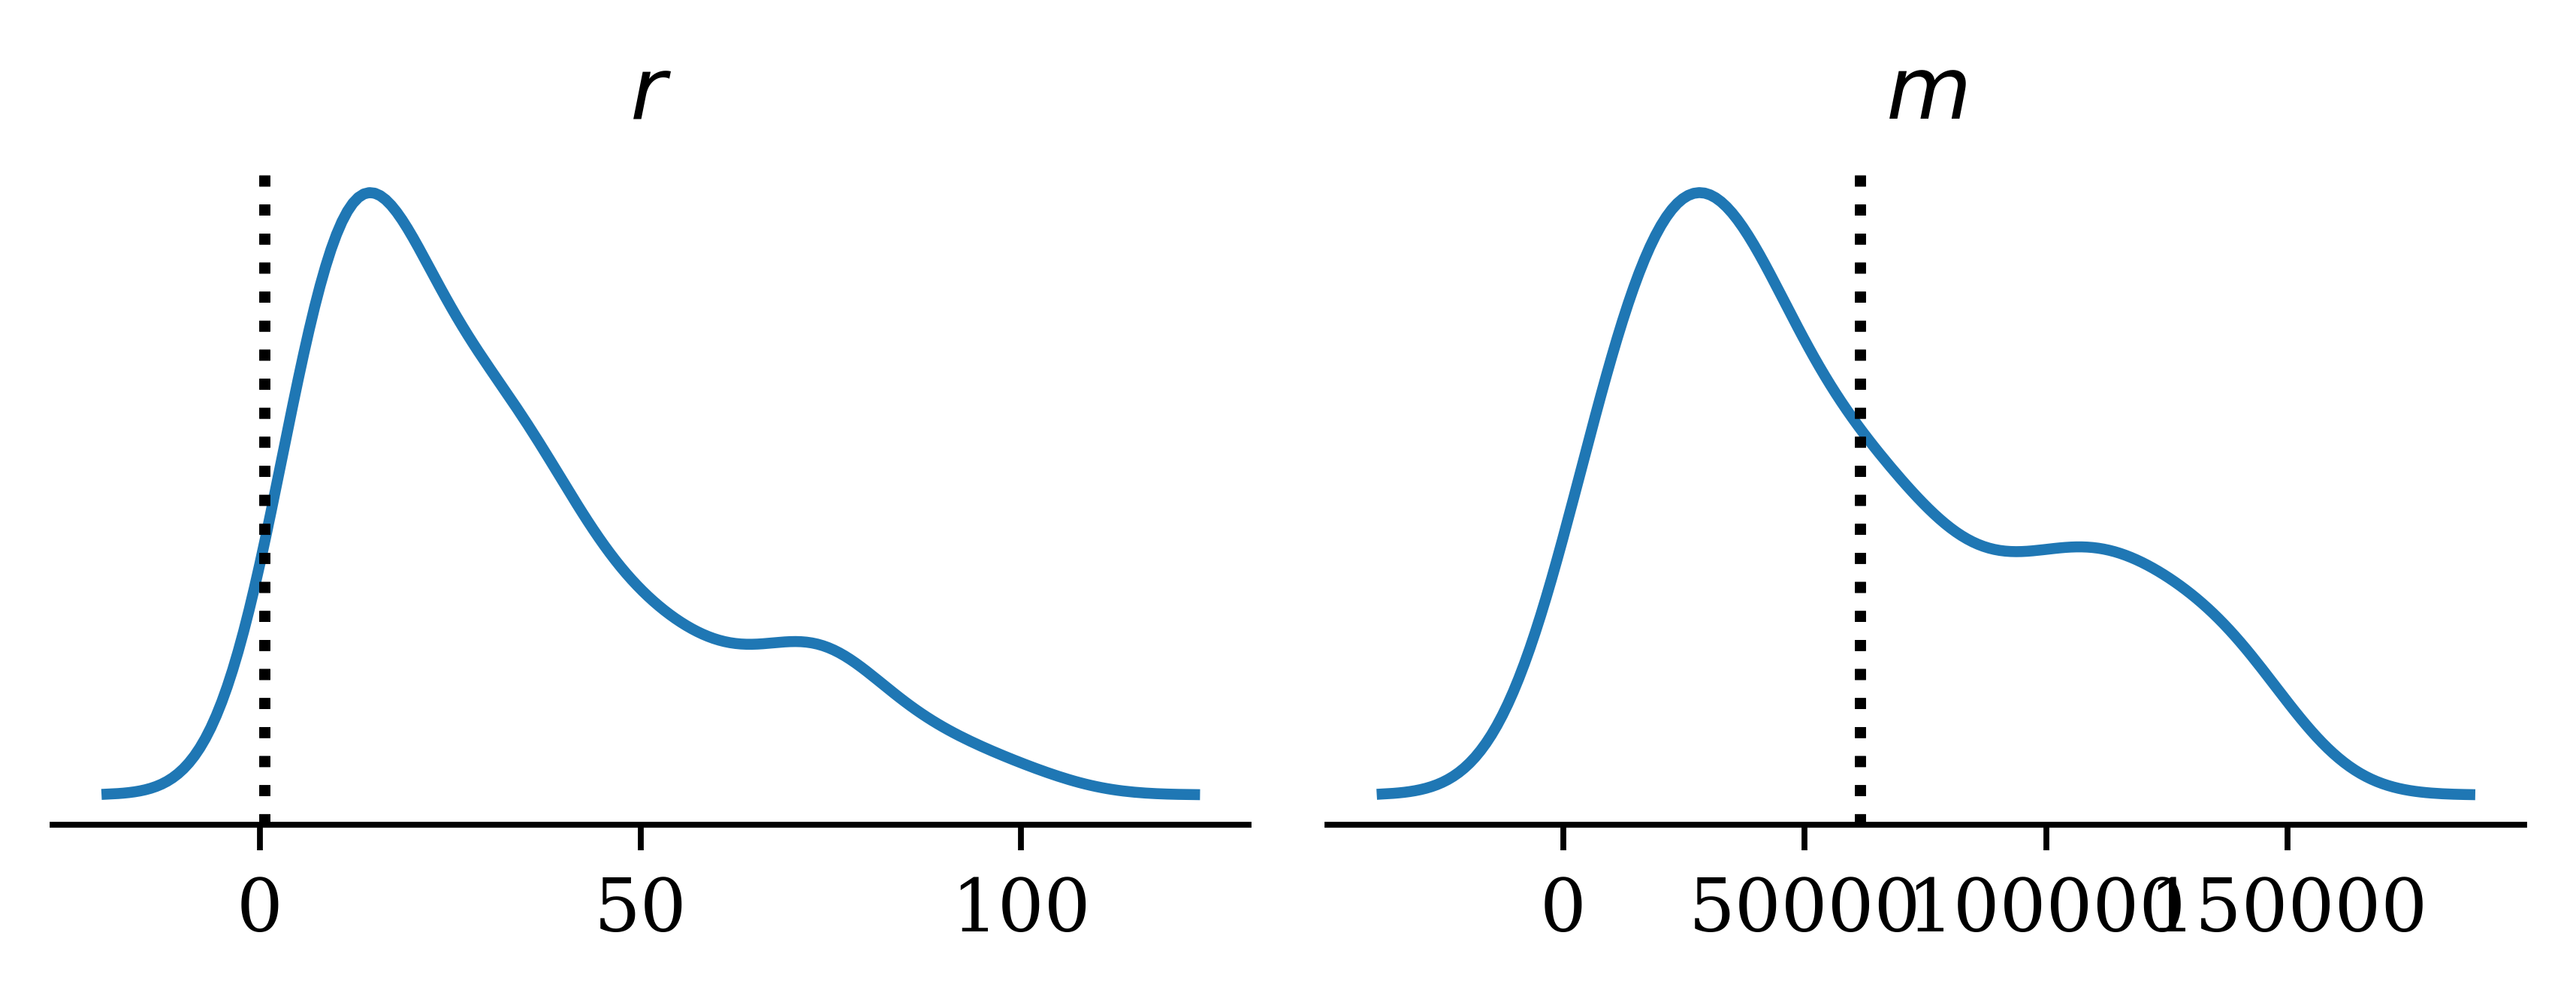

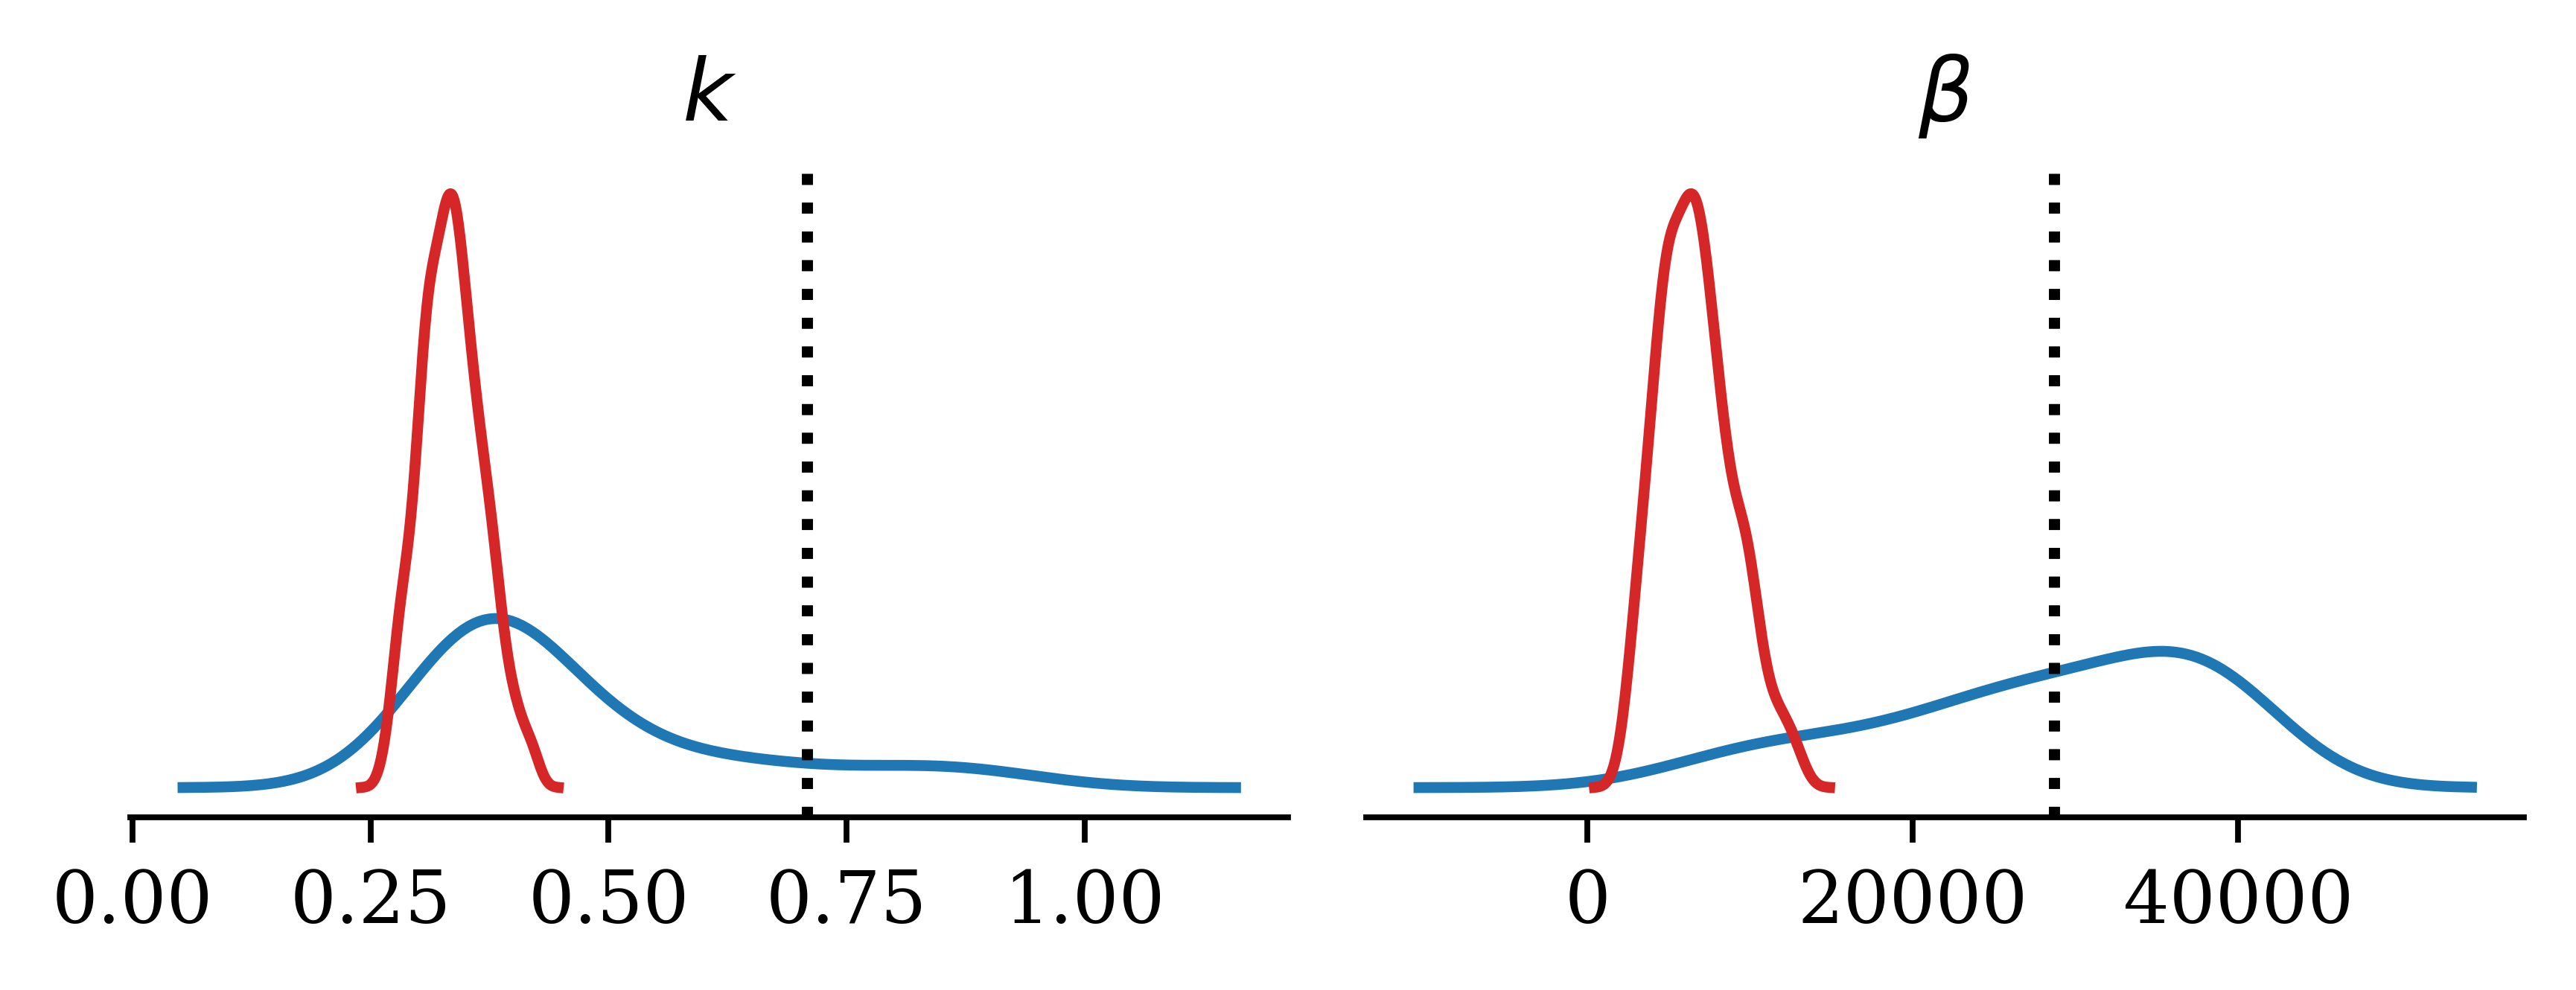

In [33]:
abc_model_sample = pd.concat(
    [
        abc_model_sample_freqs,
        abc_model_sample_nb[["model_freq", "model_sev", "weights", "param1", "param2"]],
    ]
)
params = [["μ", "σ"], ["r", "m"], ["k", "β"]]

sev_models = ["lognormal", "gamma", "weibull"]
freq_models = ["negative binomial", "With Frequencies"]
linestyles = ["solid", "solid"]

for l in range(len(sev_models)):
    fig, axs = plt.subplots(1, max(len(p) for p in params), tight_layout=True)

    for i in range(len(freq_models)):
        for k in range(len(params[l])):
            selector = (abc_model_sample.model_sev == sev_models[l]) & (
                abc_model_sample.model_freq == freq_models[i]
            )
            sample = np.array(abc_model_sample[["param1", "param2"]])[selector, k]
            weights = abc_model_sample.weights[selector].values
            if sum(weights) > 0:
                dataResampled, xs, ys = abc.resample_and_kde(
                    sample, weights / sum(weights)
                )
                axs[k].plot(xs, ys, linestyle=linestyles[i], color=prior_colors[i])

            axs[k].axvline(θ_mle[l, k + 2], **mleStyle)
            axs[k].set_title("$" + params[l][k] + "$")
            axs[k].set_yticks([])

    sns.despine(left=True)
    # save_cropped(f"../Figures/hist-RD-model-selection-freqs-{l}.pdf")

\begin{tabular}{lrrr}
\toprule
Model Severity &     Gamma &  Lognormal &   Weibull \\
Model Frequency   &           &            &           \\
\midrule
Negative Binomial &  0.911484 &   0.016297 &  0.072219 \\
With Frequencies  &  0.000000 &   0.472450 &  0.527550 \\
\bottomrule
\end{tabular}



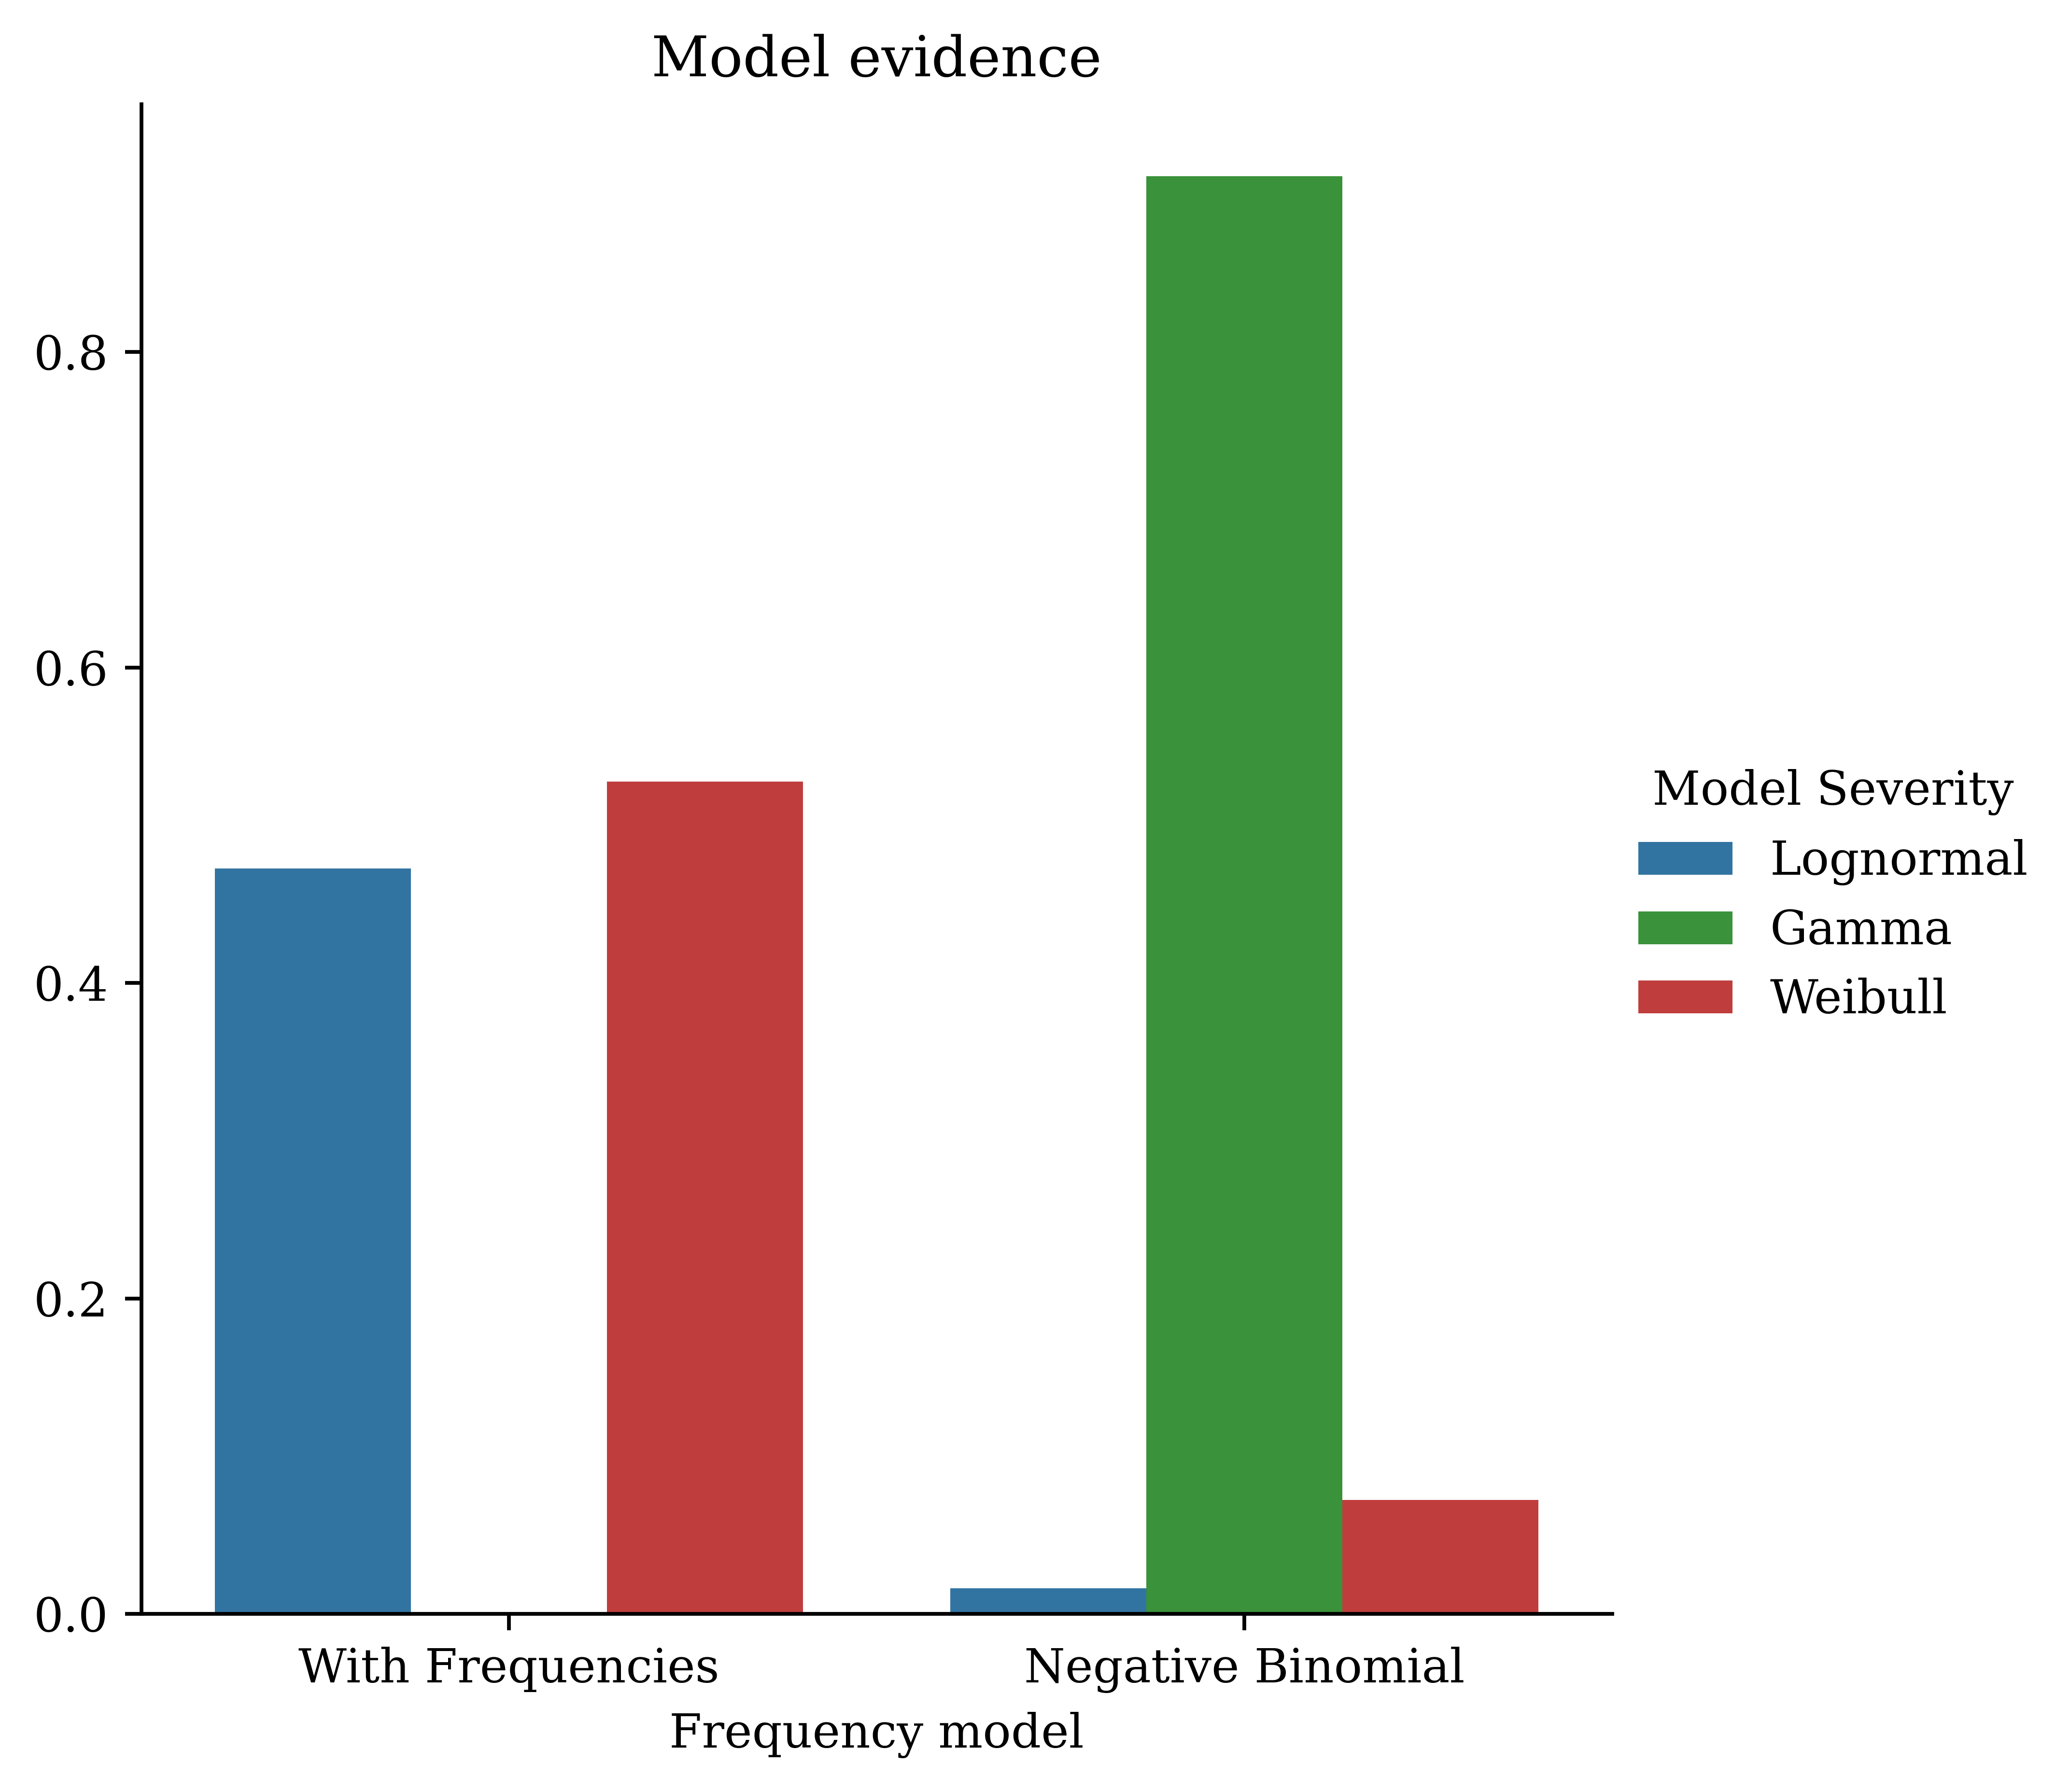

In [34]:
abc_model_prob = pd.concat([abc_model_prob_freqs, abc_model_prob_nb])

abc_model_prob = abc_model_prob.replace(
    {
        "lognormal": "Lognormal",
        "gamma": "Gamma",
        "weibull": "Weibull",
        "negative binomial": "Negative Binomial",
    }
)
abc_model_prob.columns = ["Model Frequency", "Model Severity", "Model Probability"]

g = sns.catplot(
    x="Model Frequency",
    y="Model Probability",
    hue="Model Severity",
    data=abc_model_prob,
    kind="bar",
)
plt.ylabel("")
plt.xlabel("Frequency model")
plt.title("Model evidence")

# plt.legend(title="")
# save_cropped("../Figures/barplot-RD-model-selection.pdf")

print(
    pd.pivot_table(
        abc_model_prob,
        values="Model Probability",
        index=["Model Frequency"],
        columns=["Model Severity"],
        aggfunc=np.sum,
    ).to_latex()
)

In [35]:
elapsed = toc()
print(f"Notebook time = {elapsed:.0f} secs = {elapsed/60:.2f} mins")

Notebook time = 10881 secs = 181.35 mins


In [36]:
dill.dump_session("Real_Data_Application.pkl")